In [1]:
# !pip install lifetimes
# !pip install sqlalchemy

In [2]:
from sqlalchemy import create_engine
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import summary_data_from_transaction_data
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

pd.options.display.max_columns = None  # 길어서 생략된 열 다 보이게 하기

In [3]:
from sklearn.metrics import silhouette_score

In [4]:
products = pd.read_parquet("/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/products_optimized.parquet")
products

product_id       cost           category  \
0           13842    2.51875        Accessories   
1           13928    2.33835        Accessories   
2           14115    4.87956        Accessories   
3           14157    4.64877        Accessories   
4           14273    6.50793        Accessories   
...           ...        ...                ...   
29115        5676   12.42338     Pants & Capris   
29116        6538   13.67500             Shorts   
29117        6712   12.40000             Shorts   
29118        6821   13.47500             Shorts   
29119        7809  101.84100  Blazers & Jackets   

                                            product_name  \
0       Low Profile Dyed Cotton Twill Cap - Navy W39S55D   
1      Low Profile Dyed Cotton Twill Cap - Putty W39S55D   
2           Enzyme Regular Solid Army Caps-Black W35S45D   
3      Enzyme Regular Solid Army Caps-Olive W35S45D (...   
4                  Washed Canvas Ivy Cap - Black W11S64C   
...                                                  ...   
29115  WHAT GOES AROUND COMES AROUND Women's Colette ...   
29116  WHAT GOES AROUND COMES AROUND Women's Mimi Shorts   
29117   WHAT GOES AROUND COMES AROUND Women's Fifi Short   
29118  WHAT GOES AROUND COMES AROUND Women's Ferguson...   
29119  WHAT GOES AROUND COMES AROUND Women's Bennet J...   

                               brand  retail_price department  \
0                                 MG          6.25      Women   
1                                 MG          5.95      Women   
2                                 MG         10.99      Women   
3                                 MG         10.99      Women   
4                                 MG         15.99      Women   
...                              ...           ...        ...   
29115  What Goes Around Comes Around         24.17      Women   
29116  What Goes Around Comes Around         25.00      Women   
29117  What Goes Around Comes Around         25.00      Women   
29118  What Goes Around Comes Around         25.00      Women   
29119  What Goes Around Comes Around        249.00      Women   

                                    sku  distribution_center_id  
0      EBD58B8A3F1D72F4206201DA62FB1204                       1  
1      2EAC42424D12436BDD6A5B8A88480CC3                       1  
2      EE364229B2791D1EF9355708EFF0BA34                       1  
3      00BD13095D06C20B11A2993CA419D16B                       1  
4      F531DC20FDE20B7ADF3A73F52B71D0AF                       1  
...                                 ...                     ...  
29115  3A01FC0853EBEBA94FDE4D1CC6FB842A                      10  
29116  741A0099C9AC04C7BFC822CAF7C7459F                      10  
29117  5726DAF2C9EE0F955ECA58291C26D2F3                      10  
29118  BA0A4D6ECEA3E9E126DD3B6D77291C97                      10  
29119  67C08C98984CC2BC4B9D1F0D2FE6726A                      10  

[29120 rows x 9 columns]

In [5]:
order_items = pd.read_parquet('/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/order_items_optimized.parquet')

In [6]:
# 구매건만 남기기
order_items_extracted = order_items.query('status != "Returned" and status != "Cancelled"')


In [7]:
# 'created_at' 열을 datetime 형식으로 변환
order_items_extracted['created_at'] = pd.to_datetime(order_items_extracted['created_at'])

# UTC에서 로컬 시간으로 변환
order_items_extracted['created_at'] = order_items_extracted['created_at'].dt.tz_localize(None)

# 'created_at' 열의 데이터 타입 확인
print(order_items_extracted['created_at'].dtype)

# "2023-12-01" 이전의 행만 선택
order_items_extracted = order_items_extracted.query('created_at < "2023-12-01"')

datetime64[ns]


In [8]:
# Recency 계산 (데이터 제일 최근 날짜 + 1일 기준)
recency = order_items_extracted .groupby('user_id')['created_at'].max().reset_index()
recency['recency'] = (order_items_extracted['created_at'].max()+ pd.to_timedelta(1, unit='d') - recency['created_at']).dt.days

In [9]:
# Frequency 계산
frequency = order_items_extracted.groupby('user_id')['order_id'].nunique().reset_index()

In [10]:
# Monetary 계산
monetary = order_items_extracted.groupby('user_id')['sale_price'].sum().reset_index()

In [11]:
# RFM 데이터프레임 생성
rfm = pd.merge(recency[['user_id', 'recency']], frequency, on='user_id')
rfm = pd.merge(rfm, monetary, on='user_id')
rfm = rfm.rename(columns={'order_id' : 'frequency'})
rfm= rfm.rename(columns={'sale_price' : 'monetary'})
rfm["monetary"] = rfm["monetary"] / rfm["frequency"]
rfm


user_id  recency  frequency    monetary
0            1      499          1  159.990000
1            2      649          1   22.000000
2            3      115          4  100.550000
3            4      409          1  148.000000
4            6      599          1  144.820004
...        ...      ...        ...         ...
58459    99989       91          1   15.120000
58460    99992      479          1   55.950001
58461    99996      261          2   61.935000
58462    99998      132          3   38.996667
58463   100000     1190          1  129.949997

[58464 rows x 4 columns]

array([[<Axes: title={'center': 'recency'}>]], dtype=object)

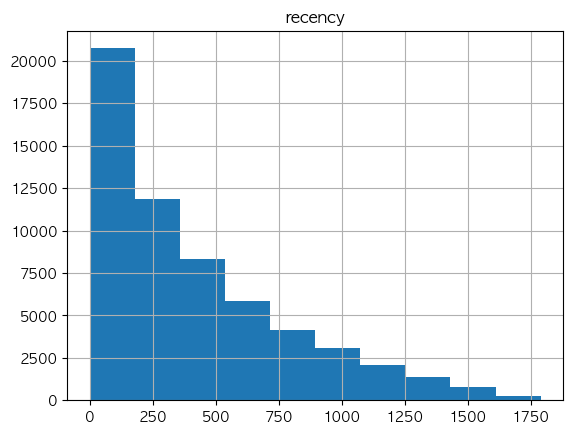

In [12]:
rfm.hist(['recency'])

In [13]:
def calculate_recency_score(recency):
    """
    recency 값을 받아서 점수로 변환하는 함수
    """
    if recency > 600:
        return 1
    else:
        return (recency // 30) + 2

# recency 값을 점수로 변환하여 새로운 열에 할당
rfm['recency_score'] = rfm['recency'].apply(calculate_recency_score)
rfm

user_id  recency  frequency    monetary  recency_score
0            1      499          1  159.990000             18
1            2      649          1   22.000000              1
2            3      115          4  100.550000              5
3            4      409          1  148.000000             15
4            6      599          1  144.820004             21
...        ...      ...        ...         ...            ...
58459    99989       91          1   15.120000              5
58460    99992      479          1   55.950001             17
58461    99996      261          2   61.935000             10
58462    99998      132          3   38.996667              6
58463   100000     1190          1  129.949997              1

[58464 rows x 5 columns]

array([[<Axes: title={'center': 'recency_score'}>]], dtype=object)

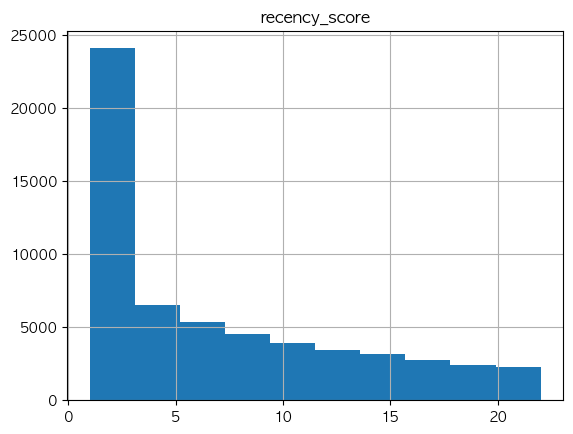

In [14]:
rfm.hist(['recency_score'])

In [15]:
def calculate_recency_score_2(recency):
    if recency <= 30:
        return 20
    elif 31 <= recency <=90:
        return 15
    elif 91 <= recency <= 180:
        return 10 
    elif 181 <= recency <= 270:
        return 5
    elif 271 <= recency <= 450:
        return 3
    elif 451 <= recency <= 720:
        return 1
    else:
        return 0.1
    

rfm['recency_score_2'] = rfm['recency'].apply(calculate_recency_score_2)
rfm

user_id  recency  frequency    monetary  recency_score  recency_score_2
0            1      499          1  159.990000             18              1.0
1            2      649          1   22.000000              1              1.0
2            3      115          4  100.550000              5             10.0
3            4      409          1  148.000000             15              3.0
4            6      599          1  144.820004             21              1.0
...        ...      ...        ...         ...            ...              ...
58459    99989       91          1   15.120000              5             10.0
58460    99992      479          1   55.950001             17              1.0
58461    99996      261          2   61.935000             10              5.0
58462    99998      132          3   38.996667              6             10.0
58463   100000     1190          1  129.949997              1              0.1

[58464 rows x 6 columns]

array([[<Axes: title={'center': 'recency_score_2'}>]], dtype=object)

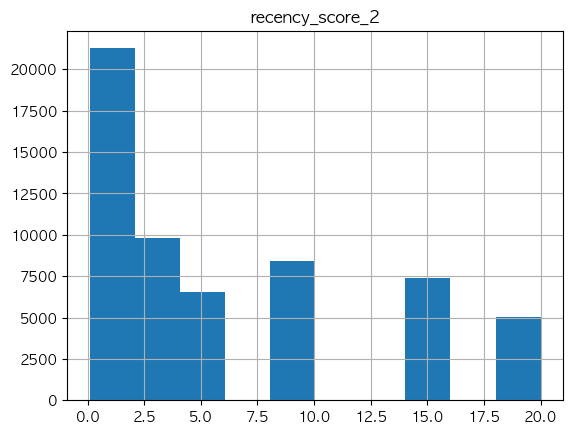

In [16]:
rfm.hist(['recency_score_2'])

In [17]:
events1 = pd.read_parquet("/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/events_optimized_divided1.parquet")
events2 = pd.read_parquet("/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/events_optimized_divided2.parquet")
events = pd.concat([events1, events2]).sort_index()
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2431963 entries, 0 to 2431962
Data columns (total 13 columns):
 #   Column                Dtype              
---  ------                -----              
 0   event_id              Int32              
 1   user_id               Int32              
 2   sequence_number       Int8               
 3   session_id            object             
 4   event_created_at      datetime64[ns, UTC]
 5   ip_address            object             
 6   city                  category           
 7   state                 category           
 8   postal_code           object             
 9   browser               category           
 10  event_traffic_source  category           
 11  uri                   object             
 12  event_type            category           
dtypes: Int32(2), Int8(1), category(5), datetime64[ns, UTC](1), object(4)
memory usage: 155.7+ MB


In [18]:
# "2023-12-01" 이전의 행만 선택
events_extracted = events[events['event_created_at'] < pd.Timestamp('2023-12-01', tz='UTC')]
events_extracted

event_id  user_id  sequence_number  \
0         2198523     <NA>                3   
1         1773216     <NA>                3   
2         2380515     <NA>                3   
3         2250597     <NA>                3   
4         1834446     <NA>                3   
...           ...      ...              ...   
2431957    964398    73628                5   
2431958    822590    62906                5   
2431959     43178     3333                5   
2431960    553230    42386               10   
2431962    844526    64551               13   

                                   session_id          event_created_at  \
0        83889ed2-2adc-4b9a-af5d-154f6998e778 2021-06-17 17:30:00+00:00   
1        7a3fc3f2-e84f-44fe-8876-eff76741f7a3 2020-08-07 08:41:00+00:00   
2        13d9b2fb-eee1-43fd-965c-267b38dd7125 2021-02-15 18:48:00+00:00   
3        96f1d44e-9621-463c-954c-d8deb7fffe7f 2022-03-30 10:56:00+00:00   
4        d09dce10-a7cb-47d3-a9af-44975566fa03 2019-09-05 01:18:00+00:00   
...                                       ...                       ...   
2431957  959d7ba8-e279-4581-97ce-bc8ef6d754db 2022-04-07 05:50:49+00:00   
2431958  12ae51e7-76b3-4560-9335-3ea762eae60e 2022-04-07 01:55:02+00:00   
2431959  e472549e-273e-402e-ae5f-38ece25699c2 2023-09-26 10:25:28+00:00   
2431960  6a7ba027-2af2-46a3-ae05-294a264840cf 2023-07-31 15:11:10+00:00   
2431962  9f633088-d2a8-4db2-8a5e-ebd946abce26 2022-09-15 09:55:32+00:00   

              ip_address          city      state postal_code  browser  \
0          138.143.9.202     São Paulo  São Paulo   02675-031   Chrome   
1          85.114.141.79  Santa Isabel  São Paulo   07500-000   Safari   
2        169.250.255.132     Mairiporã  São Paulo   07600-000       IE   
3         137.25.222.160       Cajamar  São Paulo   07750-000   Chrome   
4          161.114.4.174     São Paulo  São Paulo   09581-680   Chrome   
...                  ...           ...        ...         ...      ...   
2431957  176.114.208.145    Warrington    England         WA5   Chrome   
2431958      52.92.60.25     St Helens    England         WA9  Firefox   
2431959    97.78.106.249        Orrell    England         WN5       IE   
2431960   147.252.137.75        Orrell    England         WN5   Chrome   
2431962  190.227.140.196          York    England        YO10  Firefox   

        event_traffic_source        uri event_type  
0                    Adwords    /cancel     cancel  
1                    Adwords    /cancel     cancel  
2                    Adwords    /cancel     cancel  
3                    Adwords    /cancel     cancel  
4                      Email    /cancel     cancel  
...                      ...        ...        ...  
2431957              Adwords  /purchase   purchase  
2431958              Adwords  /purchase   purchase  
2431959                Email  /purchase   purchase  
2431960             Facebook  /purchase   purchase  
2431962                Email  /purchase   purchase  

[2220767 rows x 13 columns]

In [19]:
events_extracted[events_extracted['user_id']==1].sort_values('event_created_at')

event_id  user_id  sequence_number  \
1822544         1        1                1   
1731193         2        1                2   
1270511         3        1                3   
1375939         4        1                4   
1880043         5        1                5   
1171363         6        1                6   
2194159         7        1                7   
887742          8        1                8   
1022646         9        1                9   
1450221        11        1                1   
763416         12        1                2   
798782         13        1                3   
2070323        14        1                4   
18211          15        1                5   
1592974        16        1                6   
1871880        17        1                7   
1830531        18        1                8   
2138395        19        1                9   
481765         21        1                1   
663897         22        1                2   
997546         23        1                3   
2119605        24        1                4   
1408845        25        1                5   
749129         26        1                6   
1053469        27        1                7   
514738         28        1                8   
2014911        29        1                9   
595071         30        1               10   
1166366        10        1               10   
1563015        20        1               10   

                                   session_id          event_created_at  \
1822544  bccf01cb-6f3b-4ef7-aaff-0ea67e584334 2022-07-18 10:17:52+00:00   
1731193  bccf01cb-6f3b-4ef7-aaff-0ea67e584334 2022-07-18 10:18:43+00:00   
1270511  bccf01cb-6f3b-4ef7-aaff-0ea67e584334 2022-07-18 10:21:38+00:00   
1375939  bccf01cb-6f3b-4ef7-aaff-0ea67e584334 2022-07-18 10:21:42+00:00   
1880043  bccf01cb-6f3b-4ef7-aaff-0ea67e584334 2022-07-18 10:21:53+00:00   
1171363  bccf01cb-6f3b-4ef7-aaff-0ea67e584334 2022-07-18 10:22:53+00:00   
2194159  bccf01cb-6f3b-4ef7-aaff-0ea67e584334 2022-07-18 10:25:11+00:00   
887742   bccf01cb-6f3b-4ef7-aaff-0ea67e584334 2022-07-18 10:27:56+00:00   
1022646  bccf01cb-6f3b-4ef7-aaff-0ea67e584334 2022-07-18 10:29:16+00:00   
1450221  dc670e53-0eb4-4da2-a023-8f505d74e961 2022-07-18 10:52:33+00:00   
763416   dc670e53-0eb4-4da2-a023-8f505d74e961 2022-07-18 10:54:11+00:00   
798782   dc670e53-0eb4-4da2-a023-8f505d74e961 2022-07-18 10:55:17+00:00   
2070323  dc670e53-0eb4-4da2-a023-8f505d74e961 2022-07-18 10:57:35+00:00   
18211    dc670e53-0eb4-4da2-a023-8f505d74e961 2022-07-18 10:59:08+00:00   
1592974  dc670e53-0eb4-4da2-a023-8f505d74e961 2022-07-18 11:00:31+00:00   
1871880  dc670e53-0eb4-4da2-a023-8f505d74e961 2022-07-18 11:00:46+00:00   
1830531  dc670e53-0eb4-4da2-a023-8f505d74e961 2022-07-18 11:02:40+00:00   
2138395  dc670e53-0eb4-4da2-a023-8f505d74e961 2022-07-18 11:03:18+00:00   
481765   7ed34a21-9559-4d31-a16f-d87e4c22d343 2022-07-18 11:18:36+00:00   
663897   7ed34a21-9559-4d31-a16f-d87e4c22d343 2022-07-18 11:19:54+00:00   
997546   7ed34a21-9559-4d31-a16f-d87e4c22d343 2022-07-18 11:20:16+00:00   
2119605  7ed34a21-9559-4d31-a16f-d87e4c22d343 2022-07-18 11:22:42+00:00   
1408845  7ed34a21-9559-4d31-a16f-d87e4c22d343 2022-07-18 11:24:42+00:00   
749129   7ed34a21-9559-4d31-a16f-d87e4c22d343 2022-07-18 11:25:33+00:00   
1053469  7ed34a21-9559-4d31-a16f-d87e4c22d343 2022-07-18 11:26:31+00:00   
514738   7ed34a21-9559-4d31-a16f-d87e4c22d343 2022-07-18 11:28:05+00:00   
2014911  7ed34a21-9559-4d31-a16f-d87e4c22d343 2022-07-18 11:28:56+00:00   
595071   7ed34a21-9559-4d31-a16f-d87e4c22d343 2022-07-19 11:29:28+00:00   
1166366  bccf01cb-6f3b-4ef7-aaff-0ea67e584334 2022-07-20 10:32:05+00:00   
1563015  dc670e53-0eb4-4da2-a023-8f505d74e961 2022-07-20 11:05:38+00:00   

            ip_address          city        state postal_code  browser  \
1822544  59.203.14.177  Bucheon City  Gyeonggi-do     421-150  Firefox   
1731193  59.203.14.177  Bucheon City  Gyeonggi-do     421-150  Firefox   
127

In [20]:
event_session_count = events_extracted.groupby('user_id')['session_id'].nunique()
event_session_count

user_id
1         3
2         1
3         5
4         1
5         3
         ..
99990     1
99992     3
99996     4
99998     3
100000    2
Name: session_id, Length: 71094, dtype: int64

In [21]:
rfm = rfm.merge(event_session_count, how='left', on='user_id')
rfm

user_id  recency  frequency    monetary  recency_score  \
0            1      499          1  159.990000             18   
1            2      649          1   22.000000              1   
2            3      115          4  100.550000              5   
3            4      409          1  148.000000             15   
4            6      599          1  144.820004             21   
...        ...      ...        ...         ...            ...   
58459    99989       91          1   15.120000              5   
58460    99992      479          1   55.950001             17   
58461    99996      261          2   61.935000             10   
58462    99998      132          3   38.996667              6   
58463   100000     1190          1  129.949997              1   

       recency_score_2  session_id  
0                  1.0           3  
1                  1.0           1  
2                 10.0           5  
3                  3.0           1  
4                  1.0           2  
...                ...         ...  
58459             10.0           2  
58460              1.0           3  
58461              5.0           4  
58462             10.0           3  
58463              0.1           2  

[58464 rows x 7 columns]

In [22]:
# different_sessions = rfm[rfm['session_id_x'] != rfm['session_id_y']]
# different_sessions

In [23]:
# rfm.drop(columns=['session_id_y'], inplace=True)

rfm.rename(columns={'session_id' : 'session_count'}, inplace=True)

In [24]:
rfm['frequency_2'] = rfm['frequency'] + rfm['session_count']
rfm

user_id  recency  frequency    monetary  recency_score  \
0            1      499          1  159.990000             18   
1            2      649          1   22.000000              1   
2            3      115          4  100.550000              5   
3            4      409          1  148.000000             15   
4            6      599          1  144.820004             21   
...        ...      ...        ...         ...            ...   
58459    99989       91          1   15.120000              5   
58460    99992      479          1   55.950001             17   
58461    99996      261          2   61.935000             10   
58462    99998      132          3   38.996667              6   
58463   100000     1190          1  129.949997              1   

       recency_score_2  session_count  frequency_2  
0                  1.0              3            4  
1                  1.0              1            2  
2                 10.0              5            9  
3                  3.0              1            2  
4                  1.0              2            3  
...                ...            ...          ...  
58459             10.0              2            3  
58460              1.0              3            4  
58461              5.0              4            6  
58462             10.0              3            6  
58463              0.1              2            3  

[58464 rows x 8 columns]

array([[<Axes: title={'center': 'frequency_2'}>]], dtype=object)

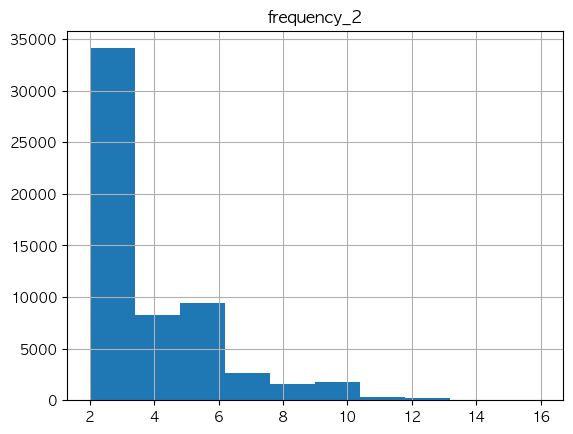

In [25]:
rfm.hist(['frequency_2'])

In [26]:
from sklearn.cluster import KMeans

# 기존 RFM model + Cluster

In [27]:
# 모델 초기화
kmeans = KMeans(n_clusters=3, random_state=42)

# RFM 데이터를 사용하여 모델 학습
rfm_data = rfm[['user_id','recency', 'frequency', 'monetary']]
kmeans.fit(rfm_data[['recency', 'frequency', 'monetary']])

# 클러스터링 결과 확인
rfm_data['cluster'] = kmeans.labels_

# 결과 출력
print(rfm_data)

       user_id  recency  frequency    monetary  cluster
0            1      499          1  159.990000        2
1            2      649          1   22.000000        2
2            3      115          4  100.550000        0
3            4      409          1  148.000000        2
4            6      599          1  144.820004        2
...        ...      ...        ...         ...      ...
58459    99989       91          1   15.120000        0
58460    99992      479          1   55.950001        2
58461    99996      261          2   61.935000        0
58462    99998      132          3   38.996667        0
58463   100000     1190          1  129.949997        1

[58464 rows x 5 columns]


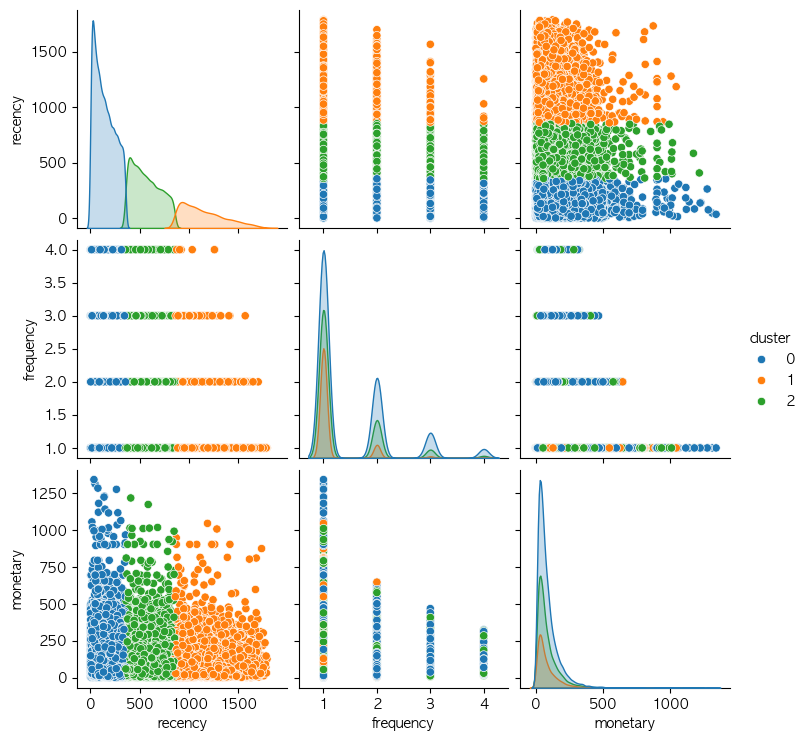

In [28]:
features = ['recency', 'frequency', 'monetary']

# 클러스터링 결과를 hue로 지정하여 시각화
sns.pairplot(rfm_data, vars=features, hue='cluster', palette='tab10', diag_kind='kde')

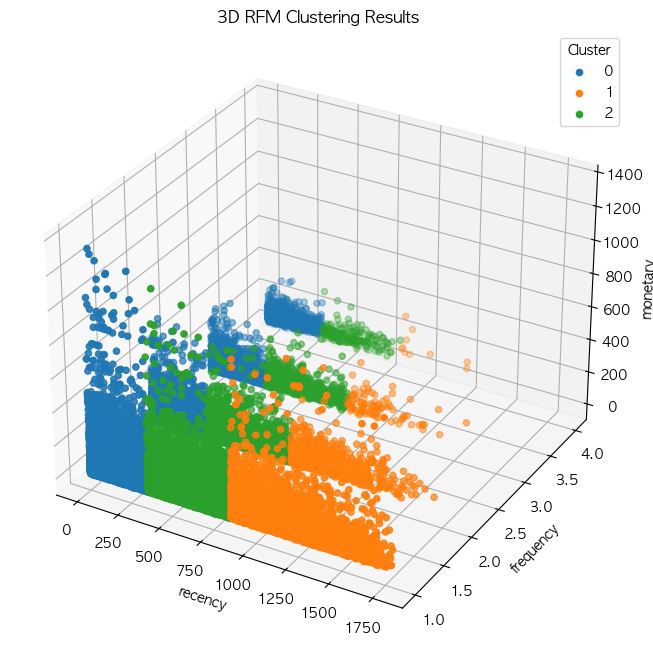

In [29]:
x_feature = 'recency'
y_feature = 'frequency'
z_feature = 'monetary'

# 클러스터링 결과를 색상으로 구분하여 3D 산점도 그리기
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label, cluster in rfm_data.groupby('cluster'):
    ax.scatter(cluster[x_feature], cluster[y_feature], cluster[z_feature], label=label)

ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(z_feature)
ax.set_title('3D RFM Clustering Results')
ax.legend(title='Cluster')

In [30]:
#from sklearn.metrics import silhouette_score

# 실루엣 점수 계산
#silhouette_avg = silhouette_score(rfm_data, rfm_data['cluster'])

# 실루엣 점수 출력
#print(f'Silhouette Score: {silhouette_avg}')

In [31]:
print(rfm_data.columns)

Index(['user_id', 'recency', 'frequency', 'monetary', 'cluster'], dtype='object')


In [32]:
import numpy as np

# GKSMS QJQ 방법론을 이용하여 각 고객의 CLV 계산
rfm_data['G'] = rfm_data['monetary']  # 과거 고객 가치 (Monetary를 사용)
rfm_data['K'] = rfm_data['monetary'] * rfm_data['frequency']  # 현재 고객 가치
rfm_data['S'] = rfm_data['monetary'] * rfm_data['frequency'] / rfm_data['recency']  # 잔존 고객 가치
rfm_data['M'] = np.log(rfm_data['frequency']) * rfm_data['monetary']  # 모멘텀 고객 가치
rfm_data['Q'] = rfm_data['monetary'] / rfm_data['frequency']  # 품질 고객 가치
rfm_data['J'] = rfm_data['monetary'] * (1/rfm_data['recency'])
#rfm_data['S'] = rfm_data['monetary'] * rfm_data['frequency'] / rfm_data['recency_scaled']  # 소셜 고객 가치
# rfm_data['J'] = rfm_data['monetary'] * np.log(rfm_data['recency_scaled'] )  # 행동 고객 가치

In [33]:
rfm_data['CLV'] = rfm_data[['G', 'K', 'S', 'M', 'Q', 'J']].sum(axis=1)
rfm_data

user_id  recency  frequency    monetary  cluster           G  \
0            1      499          1  159.990000        2  159.990000   
1            2      649          1   22.000000        2   22.000000   
2            3      115          4  100.550000        0  100.550000   
3            4      409          1  148.000000        2  148.000000   
4            6      599          1  144.820004        2  144.820004   
...        ...      ...        ...         ...      ...         ...   
58459    99989       91          1   15.120000        0   15.120000   
58460    99992      479          1   55.950001        2   55.950001   
58461    99996      261          2   61.935000        0   61.935000   
58462    99998      132          3   38.996667        0   38.996667   
58463   100000     1190          1  129.949997        1  129.949997   

                K         S           M           Q         J         CLV  
0      159.990000  0.320621    0.000000  159.990000  0.320621  480.611242  
1       22.000000  0.033898    0.000000   22.000000  0.033898   66.067797  
2      402.200001  3.497391  139.391898   25.137500  0.874348  671.651138  
3      148.000000  0.361858    0.000000  148.000000  0.361858  444.723716  
4      144.820004  0.241770    0.000000  144.820004  0.241770  434.943550  
...           ...       ...         ...         ...       ...         ...  
58459   15.120000  0.166154    0.000000   15.120000  0.166154   45.692308  
58460   55.950001  0.116806    0.000000   55.950001  0.116806  168.083614  
58461  123.870001  0.474598   42.930071   30.967500  0.237299  260.414469  
58462  116.990000  0.886288   42.842217   12.998889  0.295429  213.009490  
58463  129.949997  0.109202    0.000000  129.949997  0.109202  390.068394  

[58464 rows x 12 columns]

(array([41630.,     0.,     0., 12361.,     0.,     0.,  3386.,     0.,
            0.,  1087.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

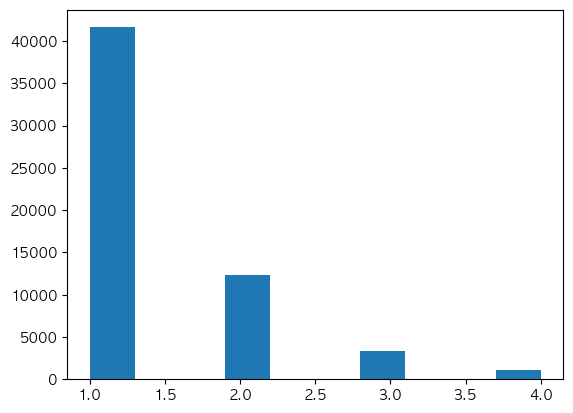

In [34]:
plt.hist(rfm_data['frequency'])

In [35]:
# Selecting relevant columns for clustering
X = rfm_data[['G', 'K', 'S', 'M', 'Q', 'J']]

# Number of clusters you want
num_clusters = 5  # You can adjust this based on your data and requirements

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Adding cluster labels to the DataFrame
rfm_data['cluster'] = kmeans.labels_

# Viewing the clusters
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['G', 'K', 'S', 'M', 'Q', 'J'])
print(cluster_centers)

# Checking the count of data points in each cluster
print(rfm_data['cluster'].value_counts())

            G           K          S             M           Q         J
0  105.928626  147.646277   2.972093  2.650354e+01   87.803528  1.910213
1  608.773079  755.258681  11.612912  9.252135e+01  545.726899  9.335825
2  258.660171  258.660171   3.405313  1.065814e-13  258.660171  3.405313
3  156.557001  388.959023  10.164957  1.372250e+02   67.084225  3.877185
4   38.415540   45.765450   0.813900  4.853559e+00   35.016985  0.641218
cluster
4    33200
0    16564
2     4225
3     4020
1      455
Name: count, dtype: int64


In [36]:
rfm_data

user_id  recency  frequency    monetary  cluster           G  \
0            1      499          1  159.990000        0  159.990000   
1            2      649          1   22.000000        4   22.000000   
2            3      115          4  100.550000        3  100.550000   
3            4      409          1  148.000000        0  148.000000   
4            6      599          1  144.820004        0  144.820004   
...        ...      ...        ...         ...      ...         ...   
58459    99989       91          1   15.120000        4   15.120000   
58460    99992      479          1   55.950001        4   55.950001   
58461    99996      261          2   61.935000        0   61.935000   
58462    99998      132          3   38.996667        4   38.996667   
58463   100000     1190          1  129.949997        0  129.949997   

                K         S           M           Q         J         CLV  
0      159.990000  0.320621    0.000000  159.990000  0.320621  480.611242  
1       22.000000  0.033898    0.000000   22.000000  0.033898   66.067797  
2      402.200001  3.497391  139.391898   25.137500  0.874348  671.651138  
3      148.000000  0.361858    0.000000  148.000000  0.361858  444.723716  
4      144.820004  0.241770    0.000000  144.820004  0.241770  434.943550  
...           ...       ...         ...         ...       ...         ...  
58459   15.120000  0.166154    0.000000   15.120000  0.166154   45.692308  
58460   55.950001  0.116806    0.000000   55.950001  0.116806  168.083614  
58461  123.870001  0.474598   42.930071   30.967500  0.237299  260.414469  
58462  116.990000  0.886288   42.842217   12.998889  0.295429  213.009490  
58463  129.949997  0.109202    0.000000  129.949997  0.109202  390.068394  

[58464 rows x 12 columns]

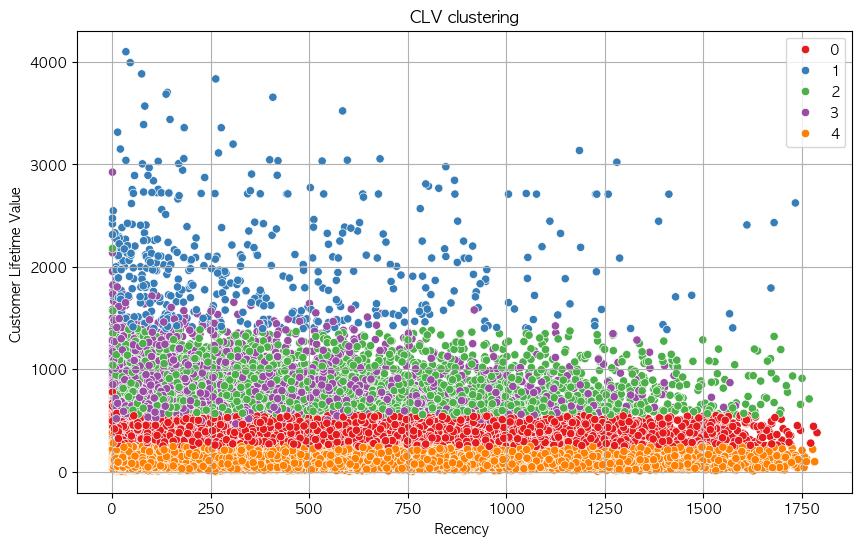

In [37]:
# 산점도 그리기
plt.figure(figsize=(10, 6))

# 각 클러스터에 대한 산점도
sns.scatterplot(x='recency', y='CLV', hue='cluster', data=rfm_data, palette='Set1')


# 라벨과 제목 추가
plt.xlabel('Recency ')
plt.ylabel('Customer Lifetime Value ')
plt.title('CLV clustering')
plt.legend()
plt.grid(True)
plt.show()

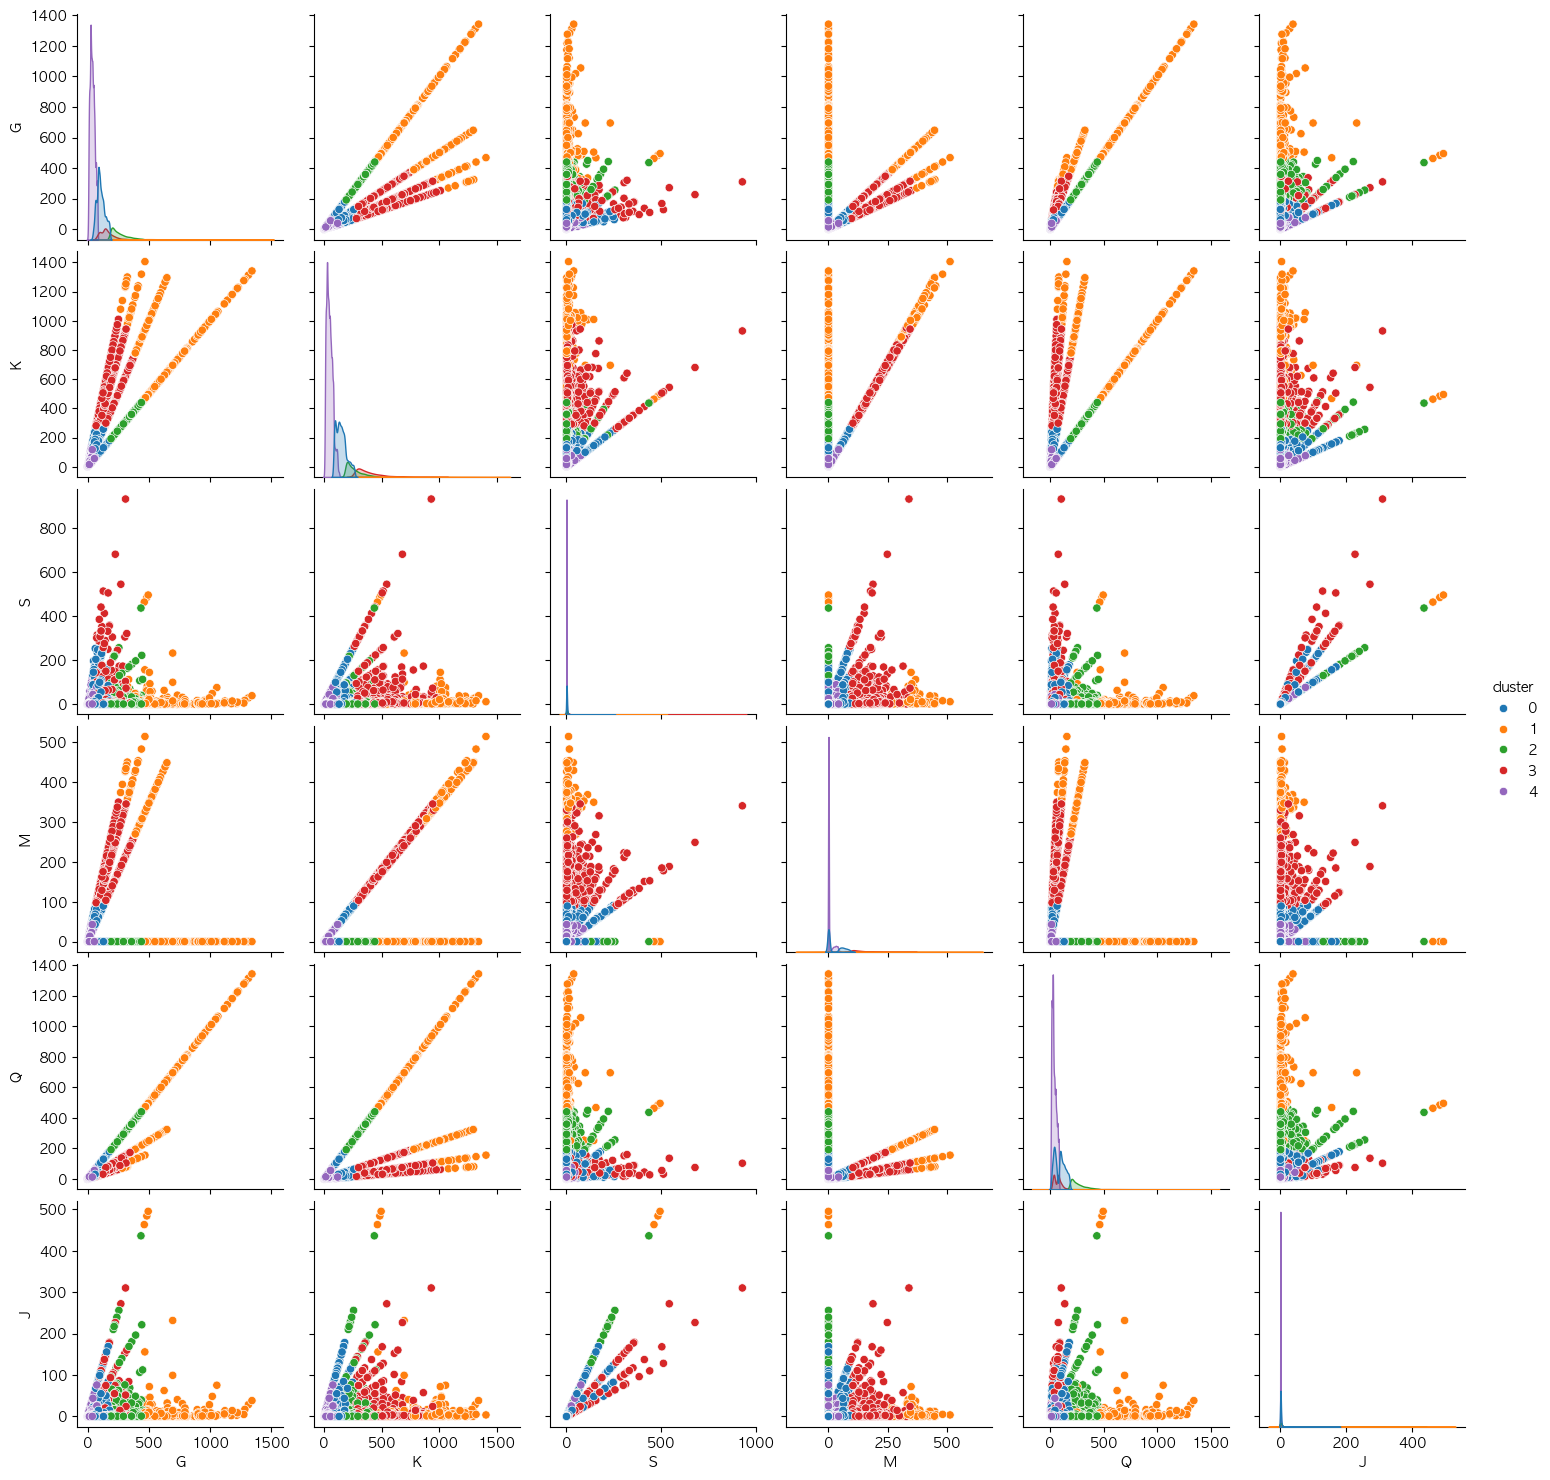

In [38]:
features = ['G', 'K', 'S', 'M', 'Q', 'J']
# 클러스터링 결과를 hue로 지정하여 시각화
sns.pairplot(rfm_data, vars=features, hue='cluster', palette='tab10', diag_kind='kde')

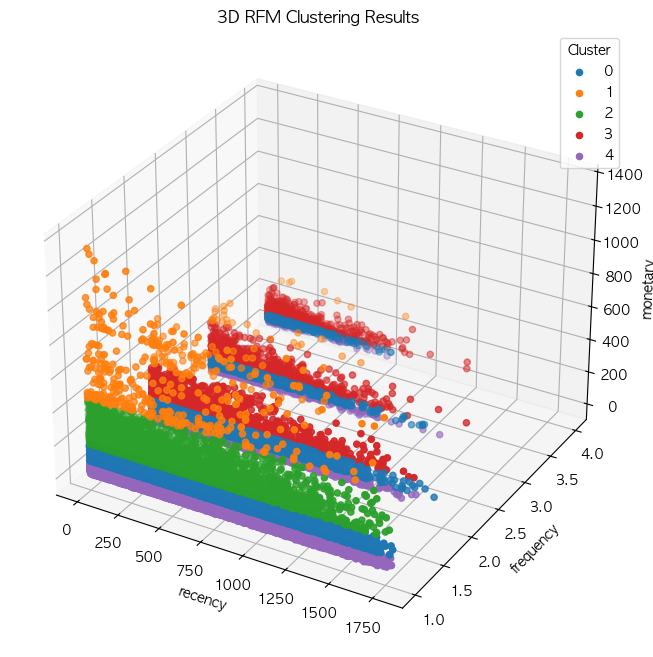

In [39]:
x_feature = 'recency'
y_feature = 'frequency'
z_feature = 'monetary'

# 클러스터링 결과를 색상으로 구분하여 3D 산점도 그리기
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label, cluster in rfm_data.groupby('cluster'):
    ax.scatter(cluster[x_feature], cluster[y_feature], cluster[z_feature], label=label)

ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(z_feature)
ax.set_title('3D RFM Clustering Results')
ax.legend(title='Cluster')

In [40]:
rfm_data.groupby('cluster').agg({
    'recency' : ['mean', 'min', 'max'],
    'frequency' : ['mean', 'min', 'max'],
    'monetary' : ['mean', 'min', 'max'],
    'CLV' : ['mean', 'min', 'max', 'count']
})

recency           frequency            monetary              \
               mean min   max      mean min max        mean         min   
cluster                                                                   
0        396.677131   1  1789  1.542743   1   4  105.924322   35.422501   
1        412.769231   1  1734  1.349451   1   4  608.773079  269.847500   
2        453.433136   1  1769  1.000000   1   1  258.660171  183.290001   
3        280.493532   1  1582  2.632836   2   4  156.557001   67.730000   
4        433.931566   1  1783  1.201235   1   4   38.413620    0.020000   

                              CLV                                   
                 max         mean          min          max  count  
cluster                                                             
0         183.129999   372.752258   235.321851   892.199993  16564  
1        1341.489998  2023.228742  1388.126963  4101.126565    455  
2         461.140000   782.791138   551.221050  2179.749947   4225  
3         372.495001   763.867380   453.443694  2925.255056   4020  
4          82.389999   125.497753     0.060153   412.491034  33200

In [41]:
rfm_data

user_id  recency  frequency    monetary  cluster           G  \
0            1      499          1  159.990000        0  159.990000   
1            2      649          1   22.000000        4   22.000000   
2            3      115          4  100.550000        3  100.550000   
3            4      409          1  148.000000        0  148.000000   
4            6      599          1  144.820004        0  144.820004   
...        ...      ...        ...         ...      ...         ...   
58459    99989       91          1   15.120000        4   15.120000   
58460    99992      479          1   55.950001        4   55.950001   
58461    99996      261          2   61.935000        0   61.935000   
58462    99998      132          3   38.996667        4   38.996667   
58463   100000     1190          1  129.949997        0  129.949997   

                K         S           M           Q         J         CLV  
0      159.990000  0.320621    0.000000  159.990000  0.320621  480.611242  
1       22.000000  0.033898    0.000000   22.000000  0.033898   66.067797  
2      402.200001  3.497391  139.391898   25.137500  0.874348  671.651138  
3      148.000000  0.361858    0.000000  148.000000  0.361858  444.723716  
4      144.820004  0.241770    0.000000  144.820004  0.241770  434.943550  
...           ...       ...         ...         ...       ...         ...  
58459   15.120000  0.166154    0.000000   15.120000  0.166154   45.692308  
58460   55.950001  0.116806    0.000000   55.950001  0.116806  168.083614  
58461  123.870001  0.474598   42.930071   30.967500  0.237299  260.414469  
58462  116.990000  0.886288   42.842217   12.998889  0.295429  213.009490  
58463  129.949997  0.109202    0.000000  129.949997  0.109202  390.068394  

[58464 rows x 12 columns]

# RFM(recency1 + frequency2) + Cluster

In [42]:
rfm

user_id  recency  frequency    monetary  recency_score  \
0            1      499          1  159.990000             18   
1            2      649          1   22.000000              1   
2            3      115          4  100.550000              5   
3            4      409          1  148.000000             15   
4            6      599          1  144.820004             21   
...        ...      ...        ...         ...            ...   
58459    99989       91          1   15.120000              5   
58460    99992      479          1   55.950001             17   
58461    99996      261          2   61.935000             10   
58462    99998      132          3   38.996667              6   
58463   100000     1190          1  129.949997              1   

       recency_score_2  session_count  frequency_2  
0                  1.0              3            4  
1                  1.0              1            2  
2                 10.0              5            9  
3                  3.0              1            2  
4                  1.0              2            3  
...                ...            ...          ...  
58459             10.0              2            3  
58460              1.0              3            4  
58461              5.0              4            6  
58462             10.0              3            6  
58463              0.1              2            3  

[58464 rows x 8 columns]

In [43]:
rfm_data

user_id  recency  frequency    monetary  cluster           G  \
0            1      499          1  159.990000        0  159.990000   
1            2      649          1   22.000000        4   22.000000   
2            3      115          4  100.550000        3  100.550000   
3            4      409          1  148.000000        0  148.000000   
4            6      599          1  144.820004        0  144.820004   
...        ...      ...        ...         ...      ...         ...   
58459    99989       91          1   15.120000        4   15.120000   
58460    99992      479          1   55.950001        4   55.950001   
58461    99996      261          2   61.935000        0   61.935000   
58462    99998      132          3   38.996667        4   38.996667   
58463   100000     1190          1  129.949997        0  129.949997   

                K         S           M           Q         J         CLV  
0      159.990000  0.320621    0.000000  159.990000  0.320621  480.611242  
1       22.000000  0.033898    0.000000   22.000000  0.033898   66.067797  
2      402.200001  3.497391  139.391898   25.137500  0.874348  671.651138  
3      148.000000  0.361858    0.000000  148.000000  0.361858  444.723716  
4      144.820004  0.241770    0.000000  144.820004  0.241770  434.943550  
...           ...       ...         ...         ...       ...         ...  
58459   15.120000  0.166154    0.000000   15.120000  0.166154   45.692308  
58460   55.950001  0.116806    0.000000   55.950001  0.116806  168.083614  
58461  123.870001  0.474598   42.930071   30.967500  0.237299  260.414469  
58462  116.990000  0.886288   42.842217   12.998889  0.295429  213.009490  
58463  129.949997  0.109202    0.000000  129.949997  0.109202  390.068394  

[58464 rows x 12 columns]

In [44]:
rfm_data = pd.merge(rfm_data, rfm[['user_id', 'recency_score', 'recency_score_2', 'frequency_2']])
rfm_data

user_id  recency  frequency    monetary  cluster           G  \
0            1      499          1  159.990000        0  159.990000   
1            2      649          1   22.000000        4   22.000000   
2            3      115          4  100.550000        3  100.550000   
3            4      409          1  148.000000        0  148.000000   
4            6      599          1  144.820004        0  144.820004   
...        ...      ...        ...         ...      ...         ...   
58459    99989       91          1   15.120000        4   15.120000   
58460    99992      479          1   55.950001        4   55.950001   
58461    99996      261          2   61.935000        0   61.935000   
58462    99998      132          3   38.996667        4   38.996667   
58463   100000     1190          1  129.949997        0  129.949997   

                K         S           M           Q         J         CLV  \
0      159.990000  0.320621    0.000000  159.990000  0.320621  480.611242   
1       22.000000  0.033898    0.000000   22.000000  0.033898   66.067797   
2      402.200001  3.497391  139.391898   25.137500  0.874348  671.651138   
3      148.000000  0.361858    0.000000  148.000000  0.361858  444.723716   
4      144.820004  0.241770    0.000000  144.820004  0.241770  434.943550   
...           ...       ...         ...         ...       ...         ...   
58459   15.120000  0.166154    0.000000   15.120000  0.166154   45.692308   
58460   55.950001  0.116806    0.000000   55.950001  0.116806  168.083614   
58461  123.870001  0.474598   42.930071   30.967500  0.237299  260.414469   
58462  116.990000  0.886288   42.842217   12.998889  0.295429  213.009490   
58463  129.949997  0.109202    0.000000  129.949997  0.109202  390.068394   

       recency_score  recency_score_2  frequency_2  
0                 18              1.0            4  
1                  1              1.0            2  
2                  5             10.0            9  
3                 15              3.0            2  
4                 21              1.0            3  
...              ...              ...          ...  
58459              5             10.0            3  
58460             17              1.0            4  
58461             10              5.0            6  
58462              6             10.0            6  
58463              1              0.1            3  

[58464 rows x 15 columns]

In [45]:
import numpy as np

# GKSMS QJQ 방법론을 이용하여 각 고객의 CLV 계산
rfm_data['G-1'] = rfm_data['monetary']  # 과거 고객 가치 (Monetary를 사용)
rfm_data['K-1'] = rfm_data['monetary'] * rfm_data['frequency_2']  # 현재 고객 가치
rfm_data['S-1'] = rfm_data['monetary'] * rfm_data['frequency_2'] / rfm_data['recency_score']  # 잔존 고객 가치
rfm_data['M-1'] = np.log(rfm_data['frequency_2']) * rfm_data['monetary']  # 모멘텀 고객 가치
#rfm_data['S'] = rfm_data['monetary'] * rfm_data['frequency_2'] / rfm_data['recency_scaled']  # 소셜 고객 가치
rfm_data['Q-1'] = rfm_data['monetary'] / rfm_data['frequency_2']  # 품질 고객 가치
# rfm_data['J'] = rfm_data['monetary'] * np.log(rfm_data['recency_scaled'] )  # 행동 고객 가치
rfm_data['J-1'] = rfm_data['monetary'] * (1/rfm_data['recency_score'])

In [46]:
rfm_data['CLV-1'] = rfm_data[['G-1', 'K-1', 'S-1', 'M-1', 'Q-1', 'J-1']].sum(axis=1)
rfm_data

user_id  recency  frequency    monetary  cluster           G  \
0            1      499          1  159.990000        0  159.990000   
1            2      649          1   22.000000        4   22.000000   
2            3      115          4  100.550000        3  100.550000   
3            4      409          1  148.000000        0  148.000000   
4            6      599          1  144.820004        0  144.820004   
...        ...      ...        ...         ...      ...         ...   
58459    99989       91          1   15.120000        4   15.120000   
58460    99992      479          1   55.950001        4   55.950001   
58461    99996      261          2   61.935000        0   61.935000   
58462    99998      132          3   38.996667        4   38.996667   
58463   100000     1190          1  129.949997        0  129.949997   

                K         S           M           Q         J         CLV  \
0      159.990000  0.320621    0.000000  159.990000  0.320621  480.611242   
1       22.000000  0.033898    0.000000   22.000000  0.033898   66.067797   
2      402.200001  3.497391  139.391898   25.137500  0.874348  671.651138   
3      148.000000  0.361858    0.000000  148.000000  0.361858  444.723716   
4      144.820004  0.241770    0.000000  144.820004  0.241770  434.943550   
...           ...       ...         ...         ...       ...         ...   
58459   15.120000  0.166154    0.000000   15.120000  0.166154   45.692308   
58460   55.950001  0.116806    0.000000   55.950001  0.116806  168.083614   
58461  123.870001  0.474598   42.930071   30.967500  0.237299  260.414469   
58462  116.990000  0.886288   42.842217   12.998889  0.295429  213.009490   
58463  129.949997  0.109202    0.000000  129.949997  0.109202  390.068394   

       recency_score  recency_score_2  frequency_2         G-1         K-1  \
0                 18              1.0            4  159.990000  639.959999   
1                  1              1.0            2   22.000000   44.000000   
2                  5             10.0            9  100.550000  904.950002   
3                 15              3.0            2  148.000000  296.000000   
4                 21              1.0            3  144.820004  434.460011   
...              ...              ...          ...         ...         ...   
58459              5             10.0            3   15.120000   45.360000   
58460             17              1.0            4   55.950001  223.800003   
58461             10              5.0            6   61.935000  371.610003   
58462              6             10.0            6   38.996667  233.980000   
58463              1              0.1            3  129.949997  389.849991   

              S-1         M-1        Q-1         J-1        CLV-1  
0       35.553333  221.793235  39.997500    8.888333  1106.182400  
1       44.000000   15.249238  11.000000   22.000000   158.249238  
2      180.990000  220.930932  11.172222   20.110000  1438.703156  
3       19.733333  102.585783  74.000000    9.866667   650.185783  
4       20.688572  159.101036  48.273335    6.896191   814.239147  
...           ...         ...        ...         ...          ...  
58459    9.072000   16.611018   5.040000    3.024000    94.227019  
58460   13.164706   77.563171  13.987500    3.291177   387.756557  
58461   37.161000  110.972623  10.322500    6.193500   598.194627  
58462   38.996667   69.872647   6.499444    6.499444   394.844868  
58463  389.849991  142.764664  43.316666  129.949997  1225.681305  

[58464 rows x 22 columns]

In [47]:
# Selecting relevant columns for clustering
X = rfm_data[['G-1', 'K-1', 'S-1', 'M-1', 'Q-1', 'J-1']]

# Number of clusters you want
num_clusters = 5  # You can adjust this based on your data and requirements

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Adding cluster labels to the DataFrame
rfm_data['cluster_r2f2'] = kmeans.labels_

# Viewing the clusters
cluster_centers2 = pd.DataFrame(kmeans.cluster_centers_, columns=['G-1', 'K-1', 'S-1', 'M-1', 'Q-1', 'J-1'])
print(cluster_centers)

# Checking the count of data points in each cluster
print(rfm_data['cluster_r2f2'].value_counts())

            G           K          S             M           Q         J
0  105.928626  147.646277   2.972093  2.650354e+01   87.803528  1.910213
1  608.773079  755.258681  11.612912  9.252135e+01  545.726899  9.335825
2  258.660171  258.660171   3.405313  1.065814e-13  258.660171  3.405313
3  156.557001  388.959023  10.164957  1.372250e+02   67.084225  3.877185
4   38.415540   45.765450   0.813900  4.853559e+00   35.016985  0.641218
cluster_r2f2
3    35656
0    14729
4     6082
2     1758
1      239
Name: count, dtype: int64


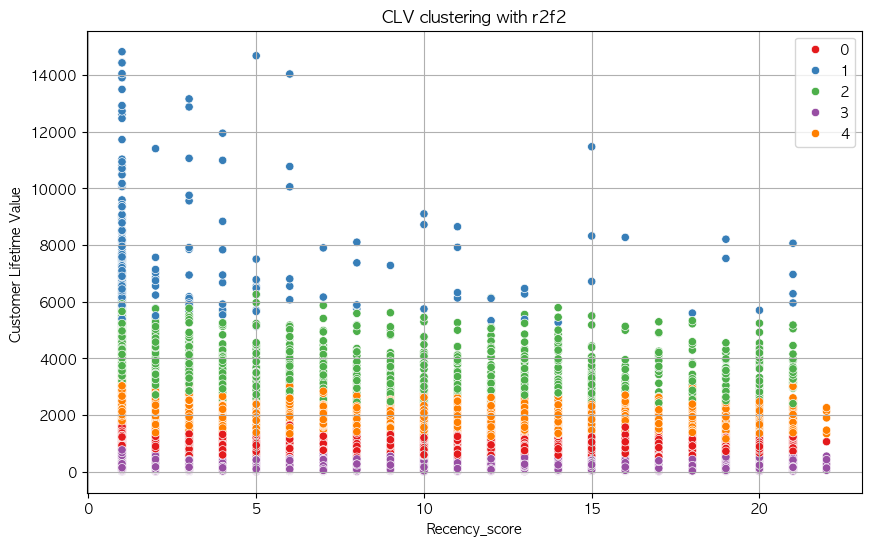

In [48]:
# 산점도 그리기
plt.figure(figsize=(10, 6))

# 각 클러스터에 대한 산점도
sns.scatterplot(x='recency_score', y='CLV-1', hue='cluster_r2f2', data=rfm_data, palette='Set1')


# 라벨과 제목 추가
plt.xlabel('Recency_score')
plt.ylabel('Customer Lifetime Value ')
plt.title('CLV clustering with r2f2')
plt.legend()
plt.grid(True)
plt.show()

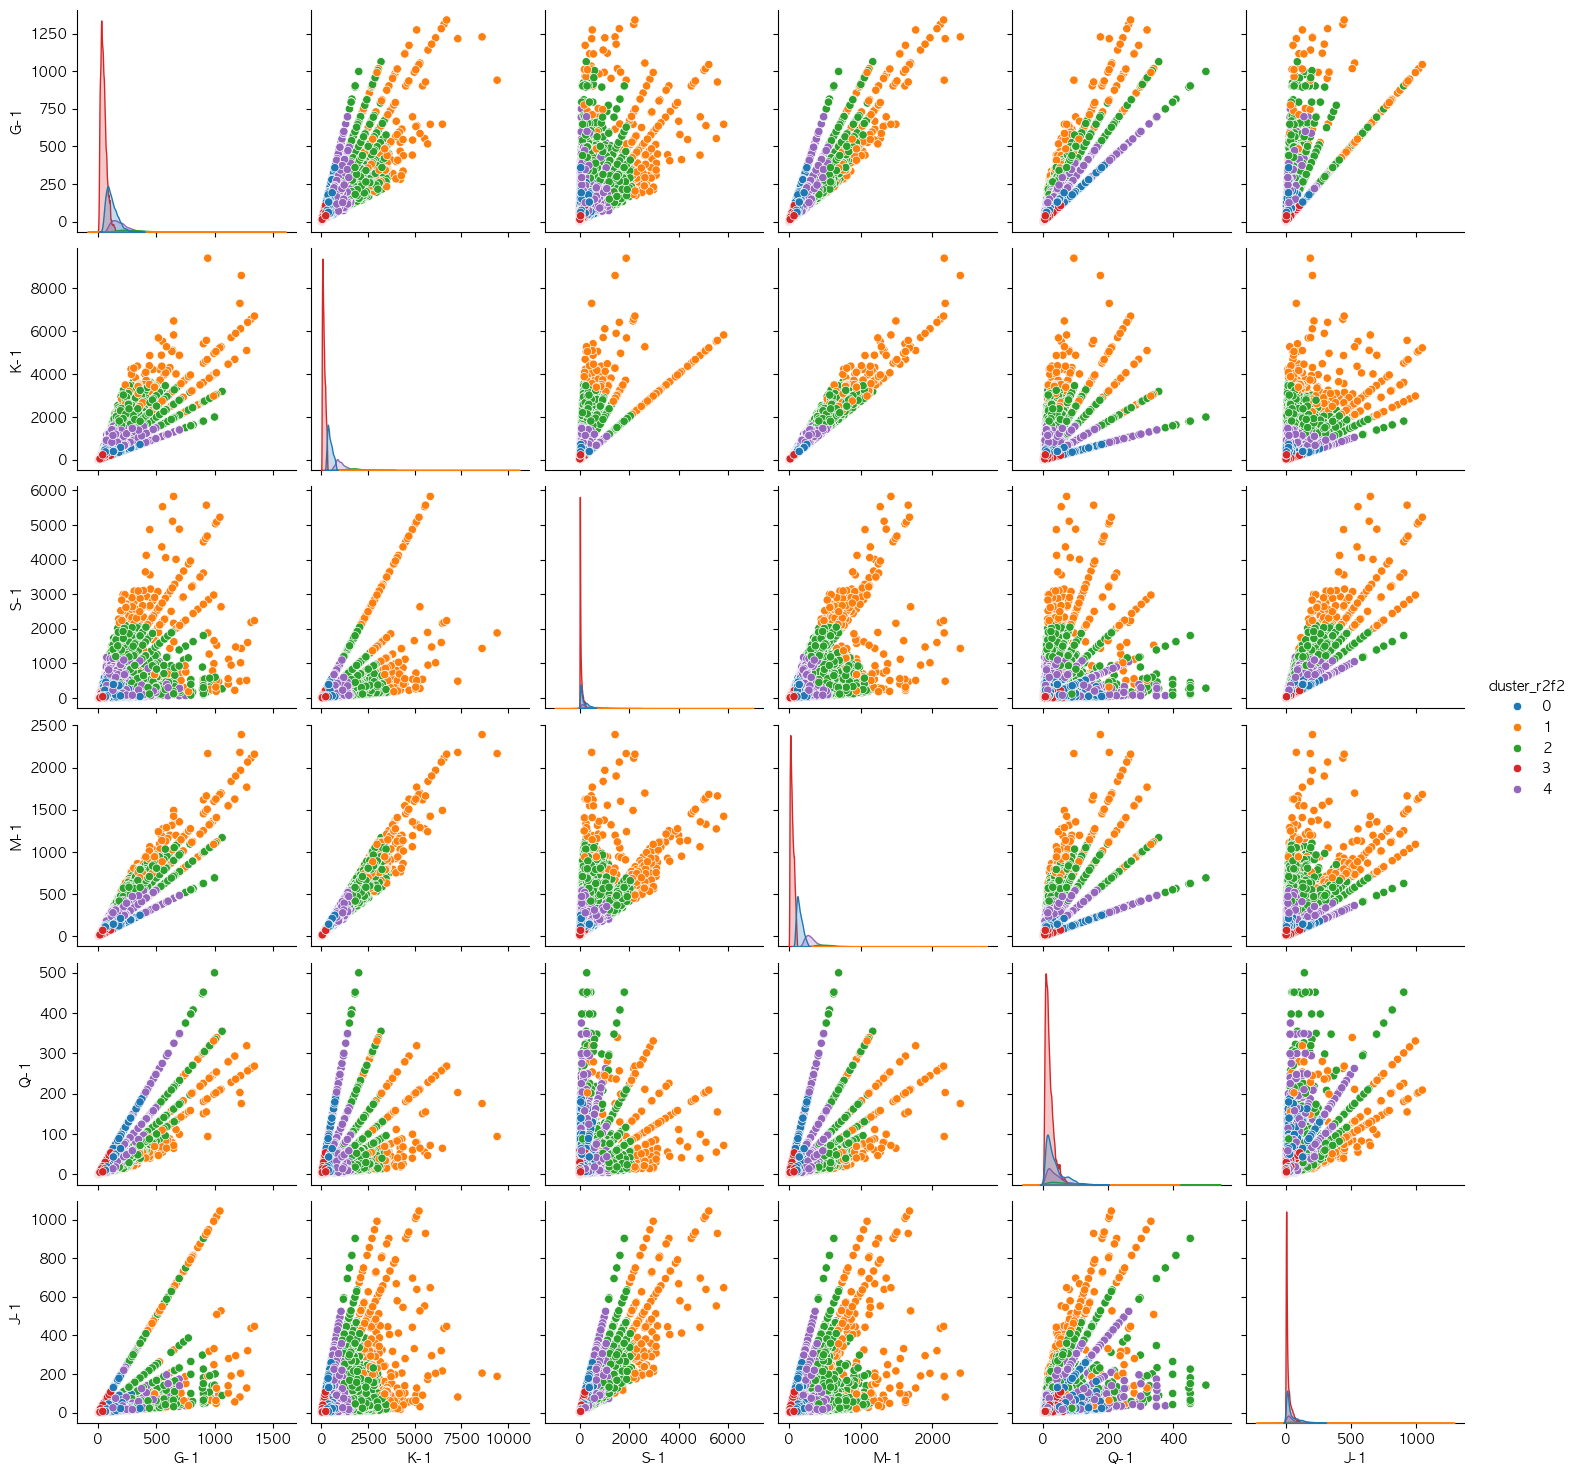

In [49]:
features = ['G-1', 'K-1', 'S-1', 'M-1', 'Q-1', 'J-1']
# 클러스터링 결과를 hue로 지정하여 시각화
sns.pairplot(rfm_data, vars=features, hue='cluster_r2f2', palette='tab10', diag_kind='kde')

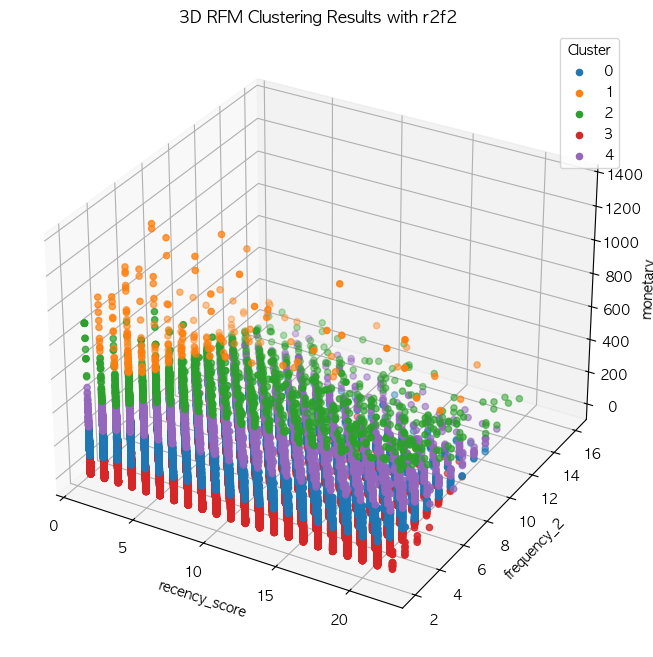

In [50]:
x_feature = 'recency_score'
y_feature = 'frequency_2'
z_feature = 'monetary'

# 클러스터링 결과를 색상으로 구분하여 3D 산점도 그리기
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label, cluster in rfm_data.groupby('cluster_r2f2'):
    ax.scatter(cluster[x_feature], cluster[y_feature], cluster[z_feature], label=label)

ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(z_feature)
ax.set_title('3D RFM Clustering Results with r2f2')
ax.legend(title='Cluster')

In [51]:
rfm_data.groupby('cluster_r2f2').agg({
    'recency_score' : ['mean', 'min', 'max'],
    'frequency_2' : ['mean', 'min', 'max'],
    'monetary' : ['mean', 'min', 'max'],
    'CLV-1' : ['mean', 'min', 'max', 'count']
})

recency_score         frequency_2            monetary  \
                      mean min max        mean min max        mean   
cluster_r2f2                                                         
0                 6.841198   1  22    4.594134   2  13  113.794280   
1                 3.313808   1  21    6.866109   3  15  560.006060   
2                 5.726394   1  21    6.873720   2  15  311.410372   
3                 7.137733   1  22    2.759255   2  11   43.470086   
4                 6.486682   1  22    6.150280   2  16  184.430543   

                                             CLV-1                             \
                     min          max         mean          min           max   
cluster_r2f2                                                                    
0              27.750000   378.000000   947.833618   477.261509   2071.626388   
1             175.375001  1341.489998  7500.444788  5134.750776  14823.941680   
2              98.023333  1063.989998  3673.324497  2294.305226   6495.411904   
3               0.020000   148.000000   277.311050     0.142726    820.018779   
4              60.955000   750.000000  1942.198029  1153.514049   3776.402270   

                     
              count  
cluster_r2f2         
0             14729  
1               239  
2              1758  
3             35656  
4              6082

# RFM(recency2 + frequency2) + Cluster

In [52]:
rfm_data

user_id  recency  frequency    monetary  cluster           G  \
0            1      499          1  159.990000        0  159.990000   
1            2      649          1   22.000000        4   22.000000   
2            3      115          4  100.550000        3  100.550000   
3            4      409          1  148.000000        0  148.000000   
4            6      599          1  144.820004        0  144.820004   
...        ...      ...        ...         ...      ...         ...   
58459    99989       91          1   15.120000        4   15.120000   
58460    99992      479          1   55.950001        4   55.950001   
58461    99996      261          2   61.935000        0   61.935000   
58462    99998      132          3   38.996667        4   38.996667   
58463   100000     1190          1  129.949997        0  129.949997   

                K         S           M           Q         J         CLV  \
0      159.990000  0.320621    0.000000  159.990000  0.320621  480.611242   
1       22.000000  0.033898    0.000000   22.000000  0.033898   66.067797   
2      402.200001  3.497391  139.391898   25.137500  0.874348  671.651138   
3      148.000000  0.361858    0.000000  148.000000  0.361858  444.723716   
4      144.820004  0.241770    0.000000  144.820004  0.241770  434.943550   
...           ...       ...         ...         ...       ...         ...   
58459   15.120000  0.166154    0.000000   15.120000  0.166154   45.692308   
58460   55.950001  0.116806    0.000000   55.950001  0.116806  168.083614   
58461  123.870001  0.474598   42.930071   30.967500  0.237299  260.414469   
58462  116.990000  0.886288   42.842217   12.998889  0.295429  213.009490   
58463  129.949997  0.109202    0.000000  129.949997  0.109202  390.068394   

       recency_score  recency_score_2  frequency_2         G-1         K-1  \
0                 18              1.0            4  159.990000  639.959999   
1                  1              1.0            2   22.000000   44.000000   
2                  5             10.0            9  100.550000  904.950002   
3                 15              3.0            2  148.000000  296.000000   
4                 21              1.0            3  144.820004  434.460011   
...              ...              ...          ...         ...         ...   
58459              5             10.0            3   15.120000   45.360000   
58460             17              1.0            4   55.950001  223.800003   
58461             10              5.0            6   61.935000  371.610003   
58462              6             10.0            6   38.996667  233.980000   
58463              1              0.1            3  129.949997  389.849991   

              S-1         M-1        Q-1         J-1        CLV-1  \
0       35.553333  221.793235  39.997500    8.888333  1106.182400   
1       44.000000   15.249238  11.000000   22.000000   158.249238   
2      180.990000  220.930932  11.172222   20.110000  1438.703156   
3       19.733333  102.585783  74.000000    9.866667   650.185783   
4       20.688572  159.101036  48.273335    6.896191   814.239147   
...           ...         ...        ...         ...          ...   
58459    9.072000   16.611018   5.040000    3.024000    94.227019   
58460   13.164706   77.563171  13.987500    3.291177   387.756557   
58461   37.161000  110.972623  10.322500    6.193500   598.194627   
58462   38.996667   69.872647   6.499444    6.499444   394.844868   
58463  389.849991  142.764664  43.316666  129.949997  1225.681305   

       cluster_r2f2  
0                 0  
1                 3  
2                 4  
3                 0  
4                 0  
...             ...  
58459             3  
58460             3  
58461             0  
58462             3  
58463             0  

[58464 rows x 23 columns]

In [53]:
# GKSMS QJQ 방법론을 이용하여 각 고객의 CLV 계산
rfm_data['G-2'] = rfm_data['monetary']  # 과거 고객 가치 (Monetary를 사용)
rfm_data['K-2'] = rfm_data['monetary'] * rfm_data['frequency_2']  # 현재 고객 가치
rfm_data['S-2'] = rfm_data['monetary'] * rfm_data['frequency_2'] / rfm_data['recency_score_2']  # 잔존 고객 가치
rfm_data['M-2'] = np.log(rfm_data['frequency_2']) * rfm_data['monetary']  # 모멘텀 고객 가치
#rfm_data['S'] = rfm_data['monetary'] * rfm_data['frequency_2'] / rfm_data['recency_scaled']  # 소셜 고객 가치
rfm_data['Q-2'] = rfm_data['monetary'] / rfm_data['frequency_2']  # 품질 고객 가치
# rfm_data['J'] = rfm_data['monetary'] * np.log(rfm_data['recency_scaled'] )  # 행동 고객 가치
rfm_data['J-2'] = rfm_data['monetary'] * (1/rfm_data['recency_score_2'])

In [54]:
rfm_data['CLV-2'] = rfm_data[['G-2', 'K-2', 'S-2', 'M-2', 'Q-2', 'J-2']].sum(axis=1)
rfm_data

user_id  recency  frequency    monetary  cluster           G  \
0            1      499          1  159.990000        0  159.990000   
1            2      649          1   22.000000        4   22.000000   
2            3      115          4  100.550000        3  100.550000   
3            4      409          1  148.000000        0  148.000000   
4            6      599          1  144.820004        0  144.820004   
...        ...      ...        ...         ...      ...         ...   
58459    99989       91          1   15.120000        4   15.120000   
58460    99992      479          1   55.950001        4   55.950001   
58461    99996      261          2   61.935000        0   61.935000   
58462    99998      132          3   38.996667        4   38.996667   
58463   100000     1190          1  129.949997        0  129.949997   

                K         S           M           Q         J         CLV  \
0      159.990000  0.320621    0.000000  159.990000  0.320621  480.611242   
1       22.000000  0.033898    0.000000   22.000000  0.033898   66.067797   
2      402.200001  3.497391  139.391898   25.137500  0.874348  671.651138   
3      148.000000  0.361858    0.000000  148.000000  0.361858  444.723716   
4      144.820004  0.241770    0.000000  144.820004  0.241770  434.943550   
...           ...       ...         ...         ...       ...         ...   
58459   15.120000  0.166154    0.000000   15.120000  0.166154   45.692308   
58460   55.950001  0.116806    0.000000   55.950001  0.116806  168.083614   
58461  123.870001  0.474598   42.930071   30.967500  0.237299  260.414469   
58462  116.990000  0.886288   42.842217   12.998889  0.295429  213.009490   
58463  129.949997  0.109202    0.000000  129.949997  0.109202  390.068394   

       recency_score  recency_score_2  frequency_2         G-1         K-1  \
0                 18              1.0            4  159.990000  639.959999   
1                  1              1.0            2   22.000000   44.000000   
2                  5             10.0            9  100.550000  904.950002   
3                 15              3.0            2  148.000000  296.000000   
4                 21              1.0            3  144.820004  434.460011   
...              ...              ...          ...         ...         ...   
58459              5             10.0            3   15.120000   45.360000   
58460             17              1.0            4   55.950001  223.800003   
58461             10              5.0            6   61.935000  371.610003   
58462              6             10.0            6   38.996667  233.980000   
58463              1              0.1            3  129.949997  389.849991   

              S-1         M-1        Q-1         J-1        CLV-1  \
0       35.553333  221.793235  39.997500    8.888333  1106.182400   
1       44.000000   15.249238  11.000000   22.000000   158.249238   
2      180.990000  220.930932  11.172222   20.110000  1438.703156   
3       19.733333  102.585783  74.000000    9.866667   650.185783   
4       20.688572  159.101036  48.273335    6.896191   814.239147   
...           ...         ...        ...         ...          ...   
58459    9.072000   16.611018   5.040000    3.024000    94.227019   
58460   13.164706   77.563171  13.987500    3.291177   387.756557   
58461   37.161000  110.972623  10.322500    6.193500   598.194627   
58462   38.996667   69.872647   6.499444    6.499444   394.844868   
58463  389.849991  142.764664  43.316666  129.949997  1225.681305   

       cluster_r2f2         G-2         K-2          S-2         M-2  \
0                 0  159.990000  639.959999   639.959999  221.793235   
1                 3   22.000000   44.000000    44.000000   15.249238   
2                 4  100.550000  904.950002    90.495000  220.930932   
3                 0  148.000000  296.000000    98.666667  102.585783   
4                 0  144.820004  434.460011   434.460011  159.101036   
...             ...         ...

In [55]:
# Selecting relevant columns for clustering
X = rfm_data[['G-2', 'K-2', 'S-2', 'M-2', 'Q-2', 'J-2']]

# Number of clusters you want
num_clusters = 5  # You can adjust this based on your data and requirements

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Adding cluster labels to the DataFrame
rfm_data['cluster_r3f2'] = kmeans.labels_

# Viewing the clusters
cluster_centers3 = pd.DataFrame(kmeans.cluster_centers_, columns=['G-2', 'K-2', 'S-2', 'M-2', 'Q-2', 'J-2'])
print(cluster_centers)

# Checking the count of data points in each cluster
print(rfm_data['cluster_r3f2'].value_counts())

            G           K          S             M           Q         J
0  105.928626  147.646277   2.972093  2.650354e+01   87.803528  1.910213
1  608.773079  755.258681  11.612912  9.252135e+01  545.726899  9.335825
2  258.660171  258.660171   3.405313  1.065814e-13  258.660171  3.405313
3  156.557001  388.959023  10.164957  1.372250e+02   67.084225  3.877185
4   38.415540   45.765450   0.813900  4.853559e+00   35.016985  0.641218
cluster_r3f2
0    51584
4     4625
2     1545
1      608
3      102
Name: count, dtype: int64


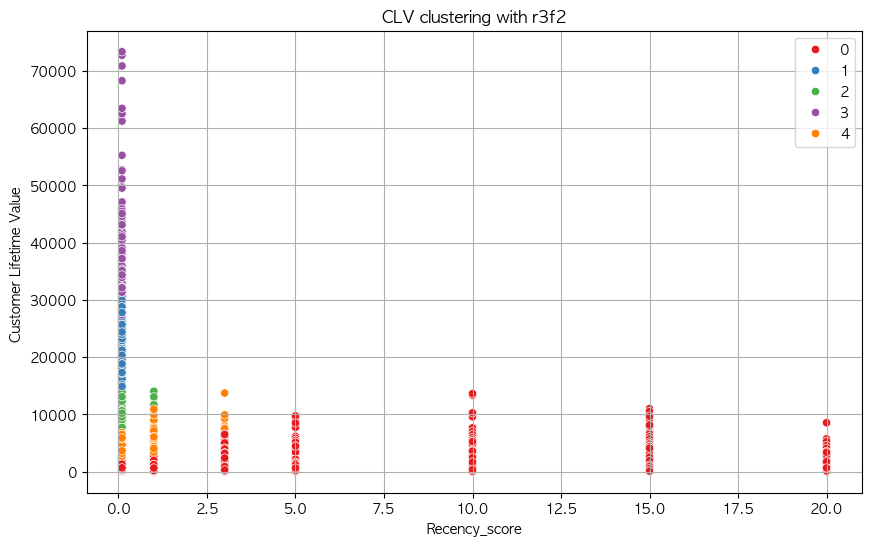

In [56]:
# 산점도 그리기
plt.figure(figsize=(10, 6))

# 각 클러스터에 대한 산점도
sns.scatterplot(x='recency_score_2', y='CLV-2', hue='cluster_r3f2', data=rfm_data, palette='Set1')


# 라벨과 제목 추가
plt.xlabel('Recency_score')
plt.ylabel('Customer Lifetime Value ')
plt.title('CLV clustering with r3f2')
plt.legend()
plt.grid(True)
plt.show()

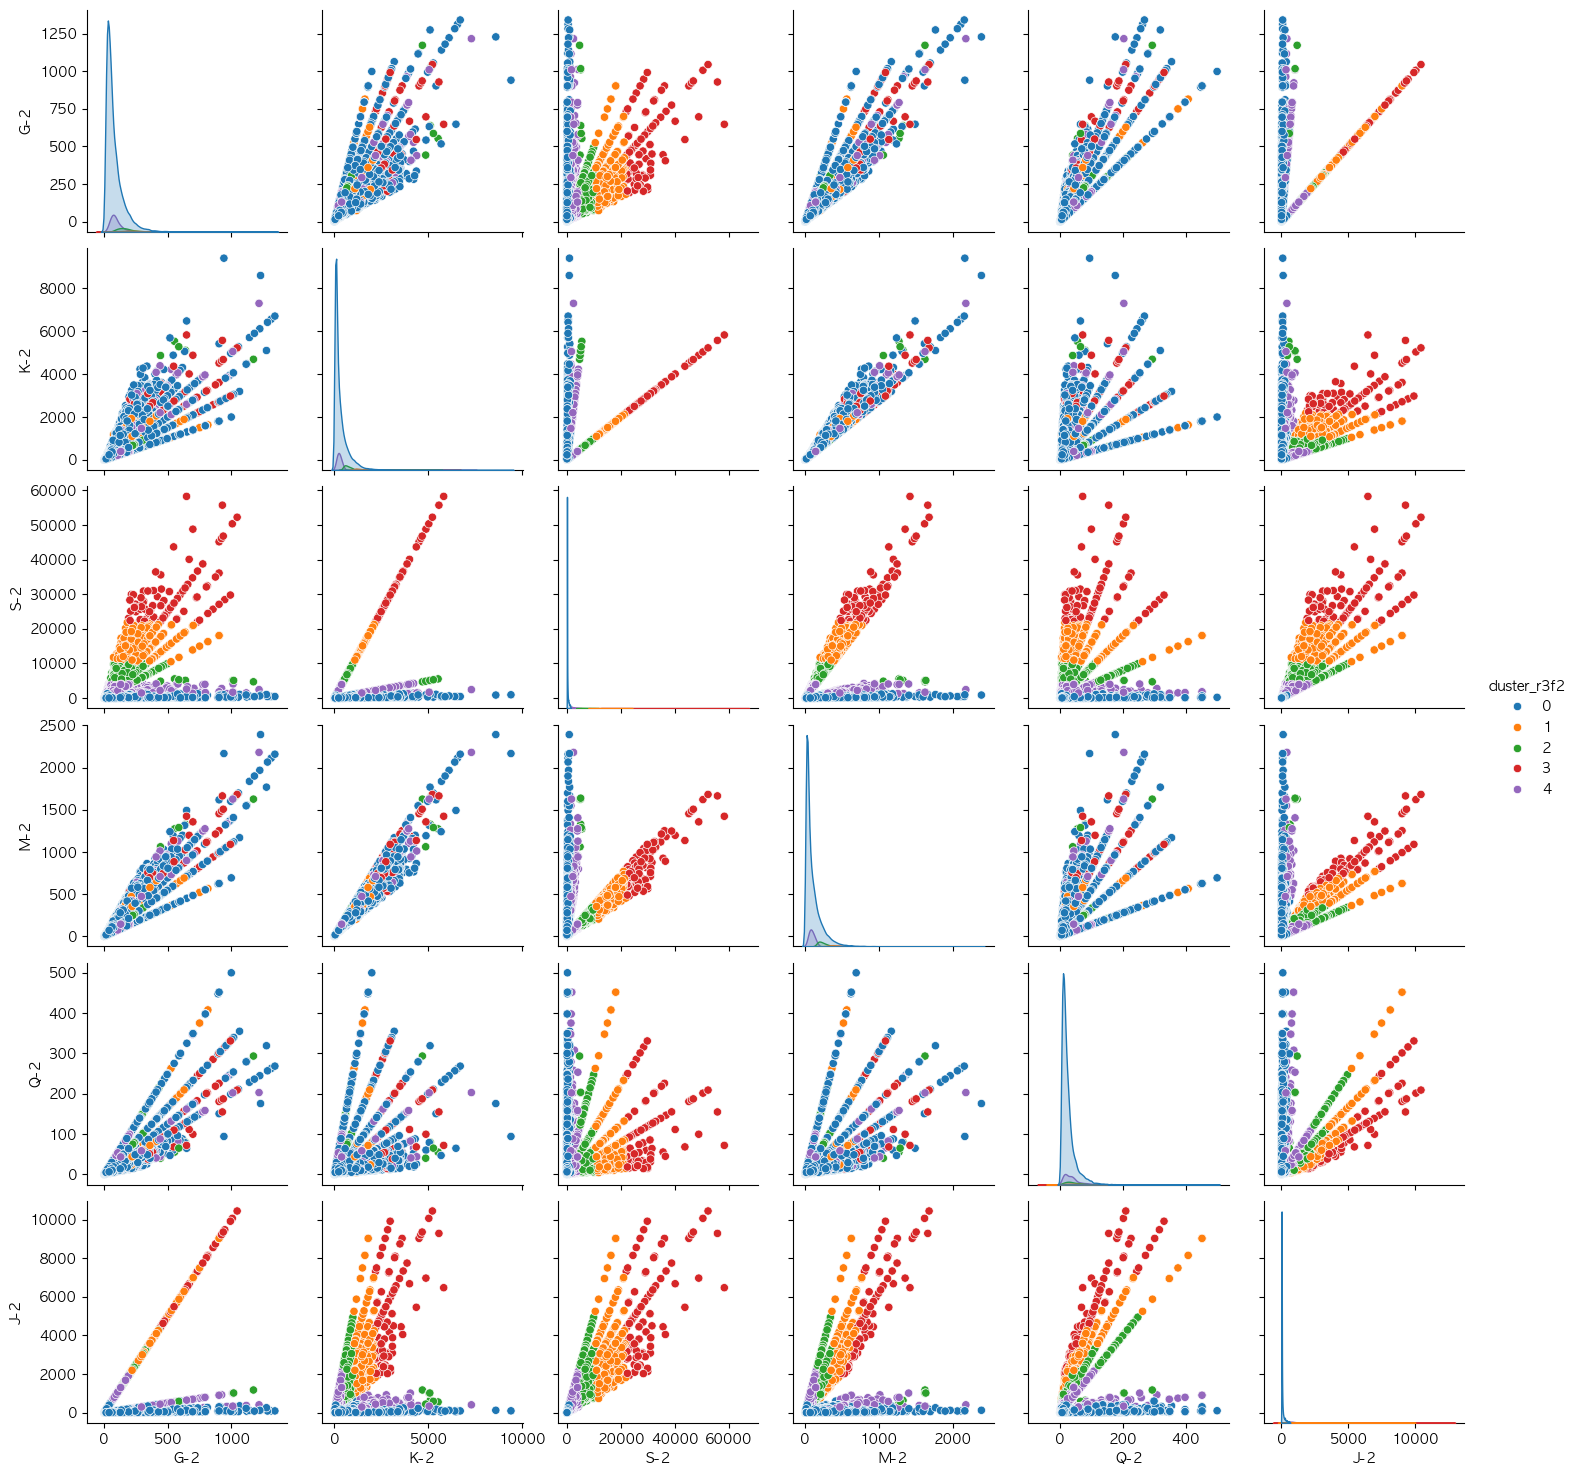

In [57]:
features = ['G-2', 'K-2', 'S-2', 'M-2', 'Q-2', 'J-2']
# 클러스터링 결과를 hue로 지정하여 시각화
sns.pairplot(rfm_data, vars=features, hue='cluster_r3f2', palette='tab10', diag_kind='kde')

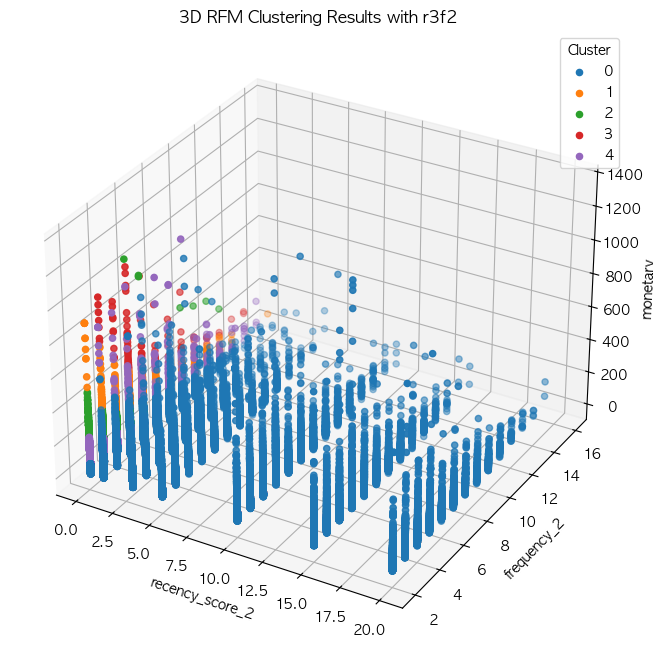

In [58]:
x_feature = 'recency_score_2'
y_feature = 'frequency_2'
z_feature = 'monetary'

# 클러스터링 결과를 색상으로 구분하여 3D 산점도 그리기
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label, cluster in rfm_data.groupby('cluster_r3f2'):
    ax.scatter(cluster[x_feature], cluster[y_feature], cluster[z_feature], label=label)

ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(z_feature)
ax.set_title('3D RFM Clustering Results with r3f2')
ax.legend(title='Cluster')

In [59]:
rfm_data.groupby('cluster_r3f2').agg({
    'recency_score_2' : ['mean', 'min', 'max'],
    'frequency_2' : ['mean', 'min', 'max'],
    'monetary' : ['mean', 'min', 'max'],
    'CLV-2' : ['mean', 'min', 'max', 'count']
})

recency_score_2            frequency_2            monetary  \
                        mean  min   max        mean min max        mean   
cluster_r3f2                                                              
0                   7.126390  0.1  20.0    3.673251   2  15   78.638365   
1                   0.100000  0.1   0.1    6.036184   2  16  266.774426   
2                   0.104078  0.1   1.0    4.601942   2  13  172.293557   
3                   0.100000  0.1   0.1    6.401961   3  14  519.277222   
4                   0.174335  0.1   3.0    3.517405   2  14  106.208145   

                                              CLV-2                \
                     min          max          mean           min   
cluster_r3f2                                                        
0               0.020000  1341.489998    746.816567      0.152726   
1              73.416667   903.000000  19014.546496  13153.341290   
2              52.879999  1173.000000   9749.122040   6092.352734   
3             191.969999  1044.990000  38852.700182  27387.300124   
4              21.960000  1216.990002   3975.748429   1854.733412   

                                   
                       max  count  
cluster_r3f2                       
0             13646.932573  51584  
1             31800.090893    608  
2             16925.607854   1545  
3             73345.271911    102  
4             13741.958375   4625

# RFM(Standard Scaling) cluster

In [86]:
rfm_data

user_id  recency  frequency    monetary  cluster           G  \
0            1      499          1  159.990000        0  159.990000   
1            2      649          1   22.000000        4   22.000000   
2            3      115          4  100.550000        3  100.550000   
3            4      409          1  148.000000        0  148.000000   
4            6      599          1  144.820004        0  144.820004   
...        ...      ...        ...         ...      ...         ...   
58459    99989       91          1   15.120000        4   15.120000   
58460    99992      479          1   55.950001        4   55.950001   
58461    99996      261          2   61.935000        0   61.935000   
58462    99998      132          3   38.996667        4   38.996667   
58463   100000     1190          1  129.949997        0  129.949997   

                K         S           M           Q         J         CLV  \
0      159.990000  0.320621    0.000000  159.990000  0.320621  480.611242   
1       22.000000  0.033898    0.000000   22.000000  0.033898   66.067797   
2      402.200001  3.497391  139.391898   25.137500  0.874348  671.651138   
3      148.000000  0.361858    0.000000  148.000000  0.361858  444.723716   
4      144.820004  0.241770    0.000000  144.820004  0.241770  434.943550   
...           ...       ...         ...         ...       ...         ...   
58459   15.120000  0.166154    0.000000   15.120000  0.166154   45.692308   
58460   55.950001  0.116806    0.000000   55.950001  0.116806  168.083614   
58461  123.870001  0.474598   42.930071   30.967500  0.237299  260.414469   
58462  116.990000  0.886288   42.842217   12.998889  0.295429  213.009490   
58463  129.949997  0.109202    0.000000  129.949997  0.109202  390.068394   

       recency_score  recency_score_2  frequency_2         G-1         K-1  \
0                 18              1.0            4  159.990000  639.959999   
1                  1              1.0            2   22.000000   44.000000   
2                  5             10.0            9  100.550000  904.950002   
3                 15              3.0            2  148.000000  296.000000   
4                 21              1.0            3  144.820004  434.460011   
...              ...              ...          ...         ...         ...   
58459              5             10.0            3   15.120000   45.360000   
58460             17              1.0            4   55.950001  223.800003   
58461             10              5.0            6   61.935000  371.610003   
58462              6             10.0            6   38.996667  233.980000   
58463              1              0.1            3  129.949997  389.849991   

              S-1         M-1        Q-1         J-1        CLV-1  \
0       35.553333  221.793235  39.997500    8.888333  1106.182400   
1       44.000000   15.249238  11.000000   22.000000   158.249238   
2      180.990000  220.930932  11.172222   20.110000  1438.703156   
3       19.733333  102.585783  74.000000    9.866667   650.185783   
4       20.688572  159.101036  48.273335    6.896191   814.239147   
...           ...         ...        ...         ...          ...   
58459    9.072000   16.611018   5.040000    3.024000    94.227019   
58460   13.164706   77.563171  13.987500    3.291177   387.756557   
58461   37.161000  110.972623  10.322500    6.193500   598.194627   
58462   38.996667   69.872647   6.499444    6.499444   394.844868   
58463  389.849991  142.764664  43.316666  129.949997  1225.681305   

       cluster_r2f2         G-2         K-2          S-2         M-2  \
0                 0  159.990000  639.959999   639.959999  221.793235   
1                 3   22.000000   44.000000    44.000000   15.249238   
2                 4  100.550000  904.950002    90.495000  220.930932   
3                 0  148.000000  296.000000    98.666667  102.585783   
4                 0  144.820004  434.460011   434.460011  159.101036   
...             ...         ...

array([[<Axes: title={'center': 'recency'}>]], dtype=object)

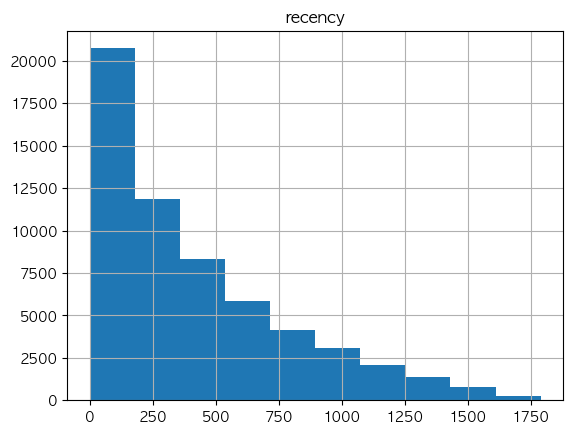

In [115]:
rfm_data.hist(['recency'])

array([[<Axes: title={'center': 'frequency_2'}>]], dtype=object)

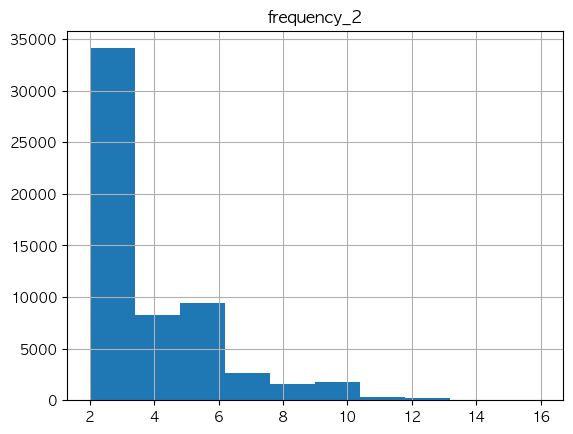

In [117]:
rfm_data.hist(['frequency_2'])

array([[<Axes: title={'center': 'monetary'}>]], dtype=object)

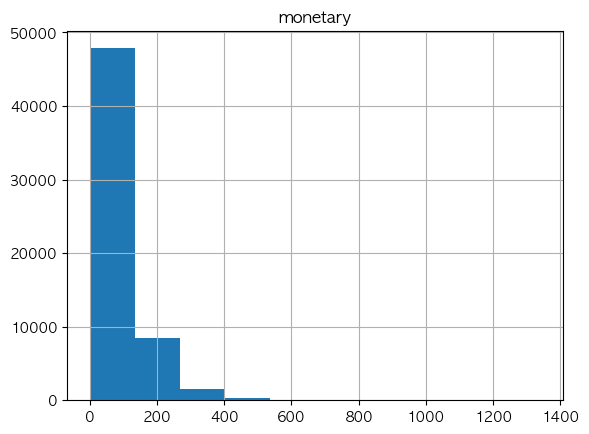

In [90]:
rfm_data.hist(['monetary'])

In [94]:
from sklearn.preprocessing import StandardScaler

In [99]:
scaler = StandardScaler()

rfm_data_scaled = rfm_data[['recency', 'frequency_2', 'monetary']].copy()
rfm_data_scaled[['recency', 'frequency_2','monetary']] = scaler.fit_transform(rfm_data_scaled[['recency', 'frequency_2','monetary']])
rfm_data_scaled

recency  frequency_2  monetary
0      0.225861     0.134654  0.861555
1      0.624773    -0.809620 -0.745656
2     -0.795352     2.495338  0.169239
3     -0.013485    -0.809620  0.721904
4      0.491803    -0.337483  0.684865
...         ...          ...       ...
58459 -0.859178    -0.337483 -0.825789
58460  0.172673     0.134654 -0.350230
58461 -0.407078     1.078928 -0.280521
58462 -0.750142     1.078928 -0.547691
58463  2.063514    -0.337483  0.511670

[58464 rows x 3 columns]

In [107]:
rfm_data_scaled.agg({
    'recency' : ['mean', 'min', 'max'],
    'frequency_2' : ['mean', 'min', 'max'],
    'monetary' : ['mean', 'min', 'max']
})

recency   frequency_2      monetary
mean -4.739868e-17  7.583789e-17  1.013603e-16
min  -1.098525e+00 -8.096196e-01 -1.001664e+00
max   3.656501e+00  5.800295e+00  1.462284e+01

In [101]:
kmeans = KMeans(n_clusters=3, random_state=42)

# RFM 데이터를 사용하여 모델 학습
# rfm_data = rfm[['user_id','recency', 'frequency', 'monetary']]
kmeans.fit(rfm_data_scaled)

# 클러스터링 결과 확인
rfm_data_scaled['rfm_cluster'] = kmeans.labels_

# 결과 출력
print(rfm_data_scaled)

        recency  frequency_2  monetary  rfm_cluster
0      0.225861     0.134654  0.861555            1
1      0.624773    -0.809620 -0.745656            2
2     -0.795352     2.495338  0.169239            1
3     -0.013485    -0.809620  0.721904            0
4      0.491803    -0.337483  0.684865            2
...         ...          ...       ...          ...
58459 -0.859178    -0.337483 -0.825789            0
58460  0.172673     0.134654 -0.350230            0
58461 -0.407078     1.078928 -0.280521            1
58462 -0.750142     1.078928 -0.547691            1
58463  2.063514    -0.337483  0.511670            2

[58464 rows x 4 columns]


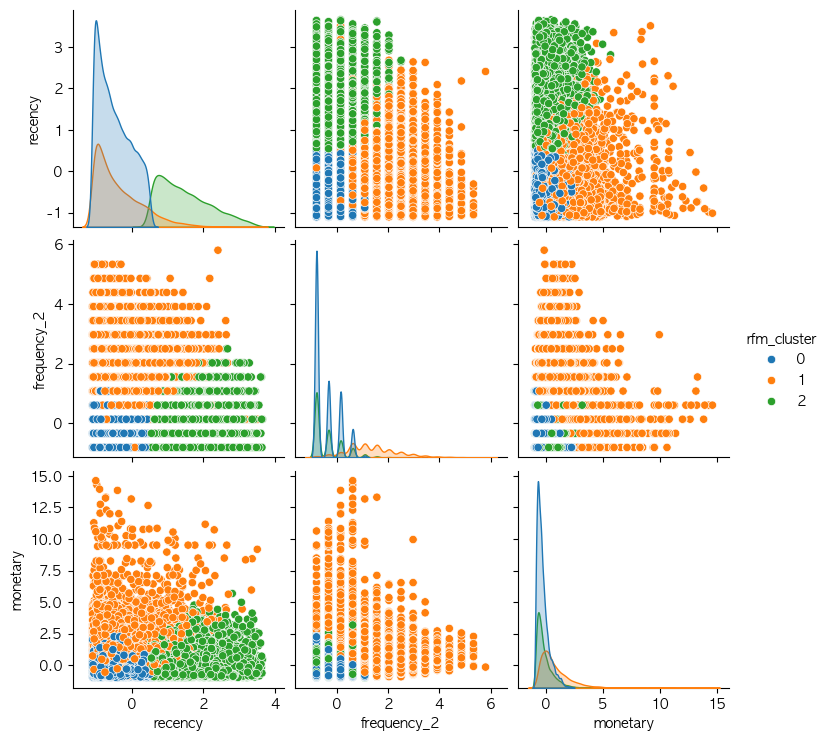

In [102]:
features = ['recency', 'frequency_2', 'monetary']

# 클러스터링 결과를 hue로 지정하여 시각화
sns.pairplot(rfm_data_scaled, vars=features, hue='rfm_cluster', palette='tab10', diag_kind='kde')

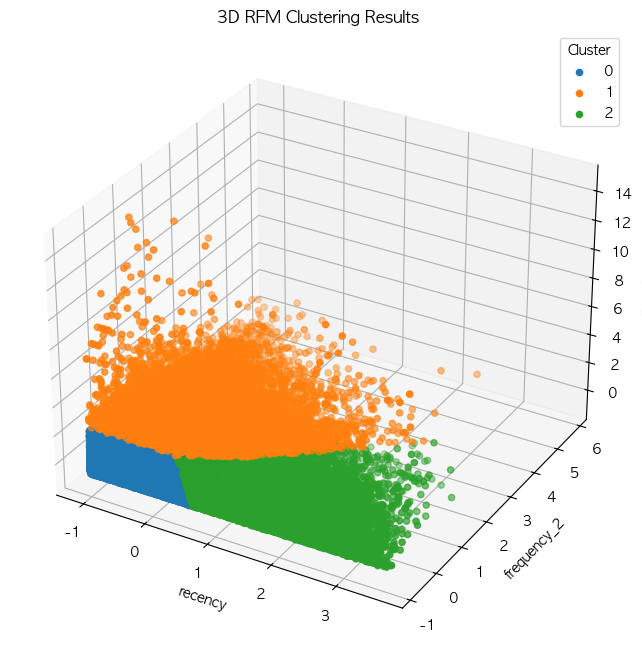

In [103]:
x_feature = 'recency'
y_feature = 'frequency_2'
z_feature = 'monetary'

# 클러스터링 결과를 색상으로 구분하여 3D 산점도 그리기
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label, cluster in rfm_data_scaled.groupby('rfm_cluster'):
    ax.scatter(cluster[x_feature], cluster[y_feature], cluster[z_feature], label=label)

ax.set_xlabel(x_feature)
ax.set_ylabel(y_feature)
ax.set_zlabel(z_feature)
ax.set_title('3D RFM Clustering Results')
ax.legend(title='Cluster')

In [112]:
rfm_data_scaled.groupby('rfm_cluster').agg({
    'recency' : ['mean', 'min', 'max'],
    'frequency_2' : ['mean', 'min', 'max'],
    'monetary' : ['mean', 'min', 'max','count'],
})

recency                     frequency_2                     \
                 mean       min       max        mean      min       max   
rfm_cluster                                                                
0           -0.485496 -1.098525  0.558288   -0.434952 -0.80962  1.078928   
1           -0.367254 -1.098525  3.510233    1.344079 -0.80962  5.800295   
2            1.478598  0.337557  3.656501   -0.395767 -0.80962  2.495338   

             monetary                              
                 mean       min        max  count  
rfm_cluster                                        
0           -0.302598 -1.001664   2.317584  30861  
1            0.810205 -0.915124  14.622838  13994  
2           -0.146927 -0.996189   5.683653  13609

In [118]:
# 역변환 수행
def inverse_scaling(scaled_value, mean, std):
    original_value = scaled_value * std + mean
    return original_value

# 평균과 표준편차 계산
original_mean = scaler.mean_
original_std = np.sqrt(scaler.var_)

# 역변환 수행
inverse_recency = inverse_scaling(rfm_data_scaled['recency'], original_mean[0], original_std[0])
inverse_frequency = inverse_scaling(rfm_data_scaled['frequency_2'], original_mean[1], original_std[1])
inverse_monetary = inverse_scaling(rfm_data_scaled['monetary'], original_mean[2], original_std[2])

# 역변환된 값을 데이터프레임에 추가
rfm_data_scaled['inverse_recency'] = inverse_recency
rfm_data_scaled['inverse_frequency'] = inverse_frequency
rfm_data_scaled['inverse_monetary'] = inverse_monetary

# 결과 출력
print(rfm_data_scaled.head())


    recency  frequency_2  monetary  rfm_cluster         G         K  \
0  0.225861     0.134654  0.861555            1  0.861555  0.116012   
1  0.624773    -0.809620 -0.745656            2 -0.745656  0.603698   
2 -0.795352     2.495338  0.169239            1  0.169239  0.422309   
3 -0.013485    -0.809620  0.721904            0  0.721904 -0.584467   
4  0.491803    -0.337483  0.684865            2  0.684865 -0.231130   

           S         M         Q          J         CLV  CLV_cluster  \
0   0.513641 -1.727458  6.398288   3.814527  480.611242            0   
1   0.966267 -0.337483  0.920995  -1.193483   66.067797            0   
2  -0.530972  0.154757  0.067822  -0.212785  671.651138            0   
3  43.340699 -0.337483 -0.891658 -53.532174  444.723716            0   
4  -0.469966 -0.337483 -2.029334   1.392562  434.943550            0   

   inverse_recency  inverse_frequency  inverse_monetary  
0            499.0                4.0        159.990000  
1            649.0      

In [120]:
rfm_data_scaled.groupby('rfm_cluster').agg({
    'inverse_recency' : ['mean', 'min', 'max'],
    'inverse_frequency' : ['mean', 'min', 'max'],
    'inverse_monetary' : ['mean', 'min', 'max','count'],
})

inverse_recency                inverse_frequency             \
                       mean    min     max              mean  min   max   
rfm_cluster                                                               
0                231.513140    1.0   624.0          2.793558  2.0   6.0   
1                275.974632    1.0  1734.0          6.561598  2.0  16.0   
2                970.058123  541.0  1789.0          2.876552  2.0   9.0   

            inverse_monetary                            
                        mean   min          max  count  
rfm_cluster                                             
0                  60.039531  0.02   285.000000  30861  
1                 155.581262  7.45  1341.489998  13994  
2                  73.404997  0.49   574.000000  13609

## RFM scaling + CLV

In [139]:
# GKSMS QJQ 방법론을 이용하여 각 고객의 CLV 계산
rfm_data_scaled['G'] = rfm_data_scaled['monetary']  # 과거 고객 가치 (Monetary를 사용)
rfm_data_scaled['K'] = rfm_data_scaled['monetary'] * rfm_data_scaled['frequency_2']  # 현재 고객 가치
rfm_data_scaled['S'] = rfm_data_scaled['monetary'] * rfm_data_scaled['frequency_2'] / rfm_data_scaled['recency']  # 잔존 고객 가치
rfm_data_scaled['M'] = np.log1p(rfm_data_scaled['frequency_2']) * rfm_data_scaled['monetary']  # 모멘텀 고객 가치
#rfm_data_scaled['S'] = rfm_data_scaled['monetary'] * rfm_data_scaled['frequency_2'] / rfm_data_scaled['recency_scaled']  # 소셜 고객 가치
rfm_data_scaled['Q'] = rfm_data_scaled['monetary'] / rfm_data_scaled['frequency_2']  # 품질 고객 가치
# rfm_data_scaled['J'] = rfm_data_scaled['monetary'] * np.log(rfm_data_scaled['recency_scaled'] )  # 행동 고객 가치
rfm_data_scaled['J'] = rfm_data_scaled['monetary'] * np.log1p(rfm_data_scaled['recency'])

/Users/hj/Documents/무제/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [108]:
# # 'frequency_2' 컬럼의 중앙값 계산
# median_frequency = rfm_data_scaled['frequency_2'].median()

# # 중앙값으로 결측값 대체
# rfm_data_scaled['M'].fillna(median_frequency, inplace=True)

In [140]:
rfm_data_scaled['CLV'] = rfm_data[['G', 'K', 'S', 'M', 'Q', 'J']].sum(axis=1)
rfm_data_scaled

recency  frequency_2  monetary  rfm_cluster         G         K  \
0      0.225861     0.134654  0.861555            1  0.861555  0.116012   
1      0.624773    -0.809620 -0.745656            2 -0.745656  0.603698   
2     -0.795352     2.495338  0.169239            1  0.169239  0.422309   
3     -0.013485    -0.809620  0.721904            0  0.721904 -0.584467   
4      0.491803    -0.337483  0.684865            2  0.684865 -0.231130   
...         ...          ...       ...          ...       ...       ...   
58459 -0.859178    -0.337483 -0.825789            0 -0.825789  0.278690   
58460  0.172673     0.134654 -0.350230            0 -0.350230 -0.047160   
58461 -0.407078     1.078928 -0.280521            1 -0.280521 -0.302662   
58462 -0.750142     1.078928 -0.547691            1 -0.547691 -0.590919   
58463  2.063514    -0.337483  0.511670            2  0.511670 -0.172680   

               S         M         Q         J         CLV  CLV_cluster  \
0       0.513641  0.108838  6.398288  0.175450  480.611242            0   
1       0.966267  1.236843  0.920995 -0.361918   66.067797            0   
2      -0.530972  0.211791  0.067822 -0.268492  671.651138            0   
3      43.340699 -1.197444 -0.891658 -0.009801  444.723716            0   
4      -0.469966 -0.281965 -2.029334  0.273936  434.943550            0   
...          ...       ...       ...       ...         ...          ...   
58459  -0.324368  0.339985  2.446908  1.618760   45.692308            0   
58460  -0.273116 -0.044244 -2.600965 -0.055787  168.083614            0   
58461   0.743498 -0.205300 -0.260000  0.146626  260.414469            0   
58462   0.787742 -0.400829 -0.507625  0.759572  213.009490            0   
58463  -0.083682 -0.210659 -1.516136  0.572846  390.068394            0   

       inverse_recency  inverse_frequency  inverse_monetary  
0                499.0                4.0        159.990000  
1                649.0                2.0         22.000000  
2                115.0                9.0        100.550000  
3                409.0                2.0        148.000000  
4                599.0                3.0        144.820004  
...                ...                ...               ...  
58459             91.0                3.0         15.120000  
58460            479.0                4.0         55.950001  
58461            261.0                6.0         61.935000  
58462            132.0                6.0         38.996667  
58463           1190.0                3.0        129.949997  

[58464 rows x 15 columns]

In [141]:
rfm_data_scaled.isnull().sum()

recency                 0
frequency_2             0
monetary                0
rfm_cluster             0
G                       0
K                       0
S                       0
M                       0
Q                       0
J                    6129
CLV                     0
CLV_cluster             0
inverse_recency         0
inverse_frequency       0
inverse_monetary        0
dtype: int64

In [131]:
# Selecting relevant columns for clustering
X = rfm_data_scaled[['G', 'K', 'S', 'M', 'Q', 'J']]

# Number of clusters you want
num_clusters = 5  # You can adjust this based on your data and requirements

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Adding cluster labels to the DataFrame
rfm_data_scaled['CLV_cluster'] = kmeans.labels_

# Viewing the clusters
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['G', 'K', 'S', 'M', 'Q', 'J'])
print(cluster_centers)

# Checking the count of data points in each cluster
print(rfm_data_scaled['CLV_cluster'].value_counts())

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

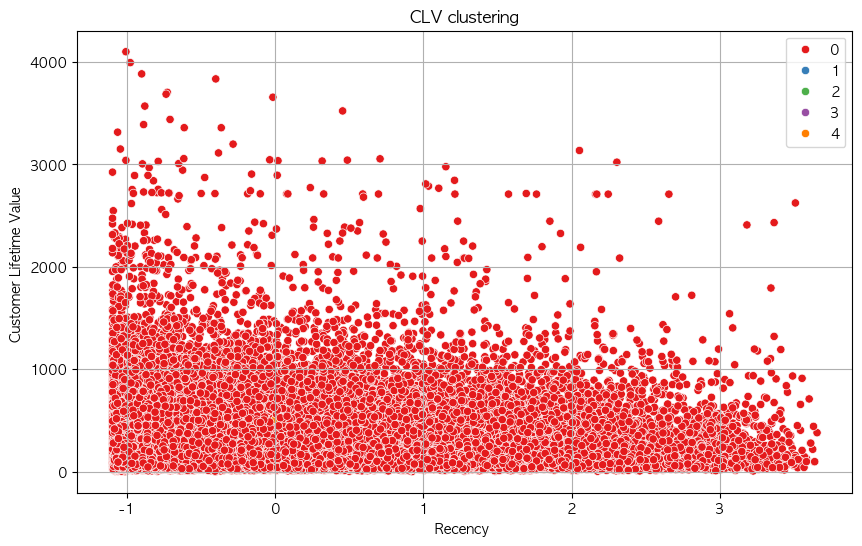

In [111]:

# 산점도 그리기
plt.figure(figsize=(10, 6))

# 각 클러스터에 대한 산점도
sns.scatterplot(x='recency', y='CLV', hue='CLV_cluster', data=rfm_data_scaled, palette='Set1')


# 라벨과 제목 추가
plt.xlabel('Recency ')
plt.ylabel('Customer Lifetime Value ')
plt.title('CLV clustering')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
order_items_extracted

order_item_id  order_id  user_id  product_id  inventory_item_id  \
1               40993     28204    22551       14235             110590   
4              131061     90241    71954       14235             353798   
5              154022    106052    84693       14235             415780   
6               67253     46269    37023       14159             181497   
7              116116     80002    63821       14159             313368   
...               ...       ...      ...         ...                ...   
181753          51581     35450    28392       23546             139190   
181755           7801      5416     4283       24447              21078   
181756          62986     43364    34691       23546             169937   
181757         106577     73418    58623       24447             287560   
181758         143759     98984    78981       24447             388091   

            status          created_at                shipped_at  \
1         Complete 2023-03-14 03:47:21 2023-03-15 22:57:00+00:00   
4          Shipped 2022-06-19 16:57:59 2022-06-19 19:29:00+00:00   
5          Shipped 2023-09-19 09:13:08 2023-09-16 09:24:00+00:00   
6         Complete 2021-10-31 01:26:46 2021-11-01 17:47:00+00:00   
7         Complete 2022-04-01 13:25:52 2022-03-31 05:13:00+00:00   
...            ...                 ...                       ...   
181753  Processing 2023-10-24 18:42:24                       NaT   
181755     Shipped 2022-01-12 23:51:07 2022-01-10 03:42:00+00:00   
181756     Shipped 2023-02-26 00:38:43 2023-02-25 06:53:00+00:00   
181757     Shipped 2023-11-12 02:41:02 2023-11-14 20:44:00+00:00   
181758     Shipped 2022-03-13 10:29:49 2022-03-14 01:27:00+00:00   

                    delivered_at returned_at  sale_price  
1      2023-03-18 01:08:00+00:00         NaT        0.02  
4                            NaT         NaT        0.02  
5                            NaT         NaT        0.02  
6      2021-11-02 13:29:00+00:00         NaT        0.49  
7      2022-04-02 22:18:00+00:00         NaT        0.49  
...                          ...         ...         ...  
181753                       NaT         NaT      999.00  
181755                       NaT         NaT      999.00  
181756                       NaT         NaT      999.00  
181757                       NaT         NaT      999.00  
181758                       NaT         NaT      999.00  

[117039 rows x 11 columns]

In [61]:
products

product_id       cost           category  \
0           13842    2.51875        Accessories   
1           13928    2.33835        Accessories   
2           14115    4.87956        Accessories   
3           14157    4.64877        Accessories   
4           14273    6.50793        Accessories   
...           ...        ...                ...   
29115        5676   12.42338     Pants & Capris   
29116        6538   13.67500             Shorts   
29117        6712   12.40000             Shorts   
29118        6821   13.47500             Shorts   
29119        7809  101.84100  Blazers & Jackets   

                                            product_name  \
0       Low Profile Dyed Cotton Twill Cap - Navy W39S55D   
1      Low Profile Dyed Cotton Twill Cap - Putty W39S55D   
2           Enzyme Regular Solid Army Caps-Black W35S45D   
3      Enzyme Regular Solid Army Caps-Olive W35S45D (...   
4                  Washed Canvas Ivy Cap - Black W11S64C   
...                                                  ...   
29115  WHAT GOES AROUND COMES AROUND Women's Colette ...   
29116  WHAT GOES AROUND COMES AROUND Women's Mimi Shorts   
29117   WHAT GOES AROUND COMES AROUND Women's Fifi Short   
29118  WHAT GOES AROUND COMES AROUND Women's Ferguson...   
29119  WHAT GOES AROUND COMES AROUND Women's Bennet J...   

                               brand  retail_price department  \
0                                 MG          6.25      Women   
1                                 MG          5.95      Women   
2                                 MG         10.99      Women   
3                                 MG         10.99      Women   
4                                 MG         15.99      Women   
...                              ...           ...        ...   
29115  What Goes Around Comes Around         24.17      Women   
29116  What Goes Around Comes Around         25.00      Women   
29117  What Goes Around Comes Around         25.00      Women   
29118  What Goes Around Comes Around         25.00      Women   
29119  What Goes Around Comes Around        249.00      Women   

                                    sku  distribution_center_id  
0      EBD58B8A3F1D72F4206201DA62FB1204                       1  
1      2EAC42424D12436BDD6A5B8A88480CC3                       1  
2      EE364229B2791D1EF9355708EFF0BA34                       1  
3      00BD13095D06C20B11A2993CA419D16B                       1  
4      F531DC20FDE20B7ADF3A73F52B71D0AF                       1  
...                                 ...                     ...  
29115  3A01FC0853EBEBA94FDE4D1CC6FB842A                      10  
29116  741A0099C9AC04C7BFC822CAF7C7459F                      10  
29117  5726DAF2C9EE0F955ECA58291C26D2F3                      10  
29118  BA0A4D6ECEA3E9E126DD3B6D77291C97                      10  
29119  67C08C98984CC2BC4B9D1F0D2FE6726A                      10  

[29120 rows x 9 columns]

In [62]:
rfm_merged = rfm_data.merge(order_items_extracted, on ='user_id', how='left').merge(products, on='product_id')
rfm_merged

user_id  recency  frequency    monetary  cluster           G  \
0             1      499          1  159.990000        0  159.990000   
1             1      499          1  159.990000        0  159.990000   
2             1      499          1  159.990000        0  159.990000   
3             2      649          1   22.000000        4   22.000000   
4             3      115          4  100.550000        3  100.550000   
...         ...      ...        ...         ...      ...         ...   
117034    99996      261          2   61.935000        0   61.935000   
117035    99998      132          3   38.996667        4   38.996667   
117036    99998      132          3   38.996667        4   38.996667   
117037    99998      132          3   38.996667        4   38.996667   
117038   100000     1190          1  129.949997        0  129.949997   

                 K         S           M           Q         J         CLV  \
0       159.990000  0.320621    0.000000  159.990000  0.320621  480.611242   
1       159.990000  0.320621    0.000000  159.990000  0.320621  480.611242   
2       159.990000  0.320621    0.000000  159.990000  0.320621  480.611242   
3        22.000000  0.033898    0.000000   22.000000  0.033898   66.067797   
4       402.200001  3.497391  139.391898   25.137500  0.874348  671.651138   
...            ...       ...         ...         ...       ...         ...   
117034  123.870001  0.474598   42.930071   30.967500  0.237299  260.414469   
117035  116.990000  0.886288   42.842217   12.998889  0.295429  213.009490   
117036  116.990000  0.886288   42.842217   12.998889  0.295429  213.009490   
117037  116.990000  0.886288   42.842217   12.998889  0.295429  213.009490   
117038  129.949997  0.109202    0.000000  129.949997  0.109202  390.068394   

        recency_score  recency_score_2  frequency_2         G-1         K-1  \
0                  18              1.0            4  159.990000  639.959999   
1                  18              1.0            4  159.990000  639.959999   
2                  18              1.0            4  159.990000  639.959999   
3                   1              1.0            2   22.000000   44.000000   
4                   5             10.0            9  100.550000  904.950002   
...               ...              ...          ...         ...         ...   
117034             10              5.0            6   61.935000  371.610003   
117035              6             10.0            6   38.996667  233.980000   
117036              6             10.0            6   38.996667  233.980000   
117037              6             10.0            6   38.996667  233.980000   
117038              1              0.1            3  129.949997  389.849991   

               S-1         M-1        Q-1         J-1        CLV-1  \
0        35.553333  221.793235  39.997500    8.888333  1106.182400   
1        35.553333  221.793235  39.997500    8.888333  1106.182400   
2        35.553333  221.793235  39.997500    8.888333  1106.182400   
3        44.000000   15.249238  11.000000   22.000000   158.249238   
4       180.990000  220.930932  11.172222   20.110000  1438.703156   
...            ...         ...        ...         ...          ...   
117034   37.161000  110.972623  10.322500    6.193500   598.194627   
117035   38.996667   69.872647   6.499444    6.499444   394.844868   
117036   38.996667   69.872647   6.499444    6.499444   394.844868   
117037   38.996667   69.872647   6.499444    6.499444   394.844868   
117038  389.849991  142.764664  43.316666  129.949997  1225.681305   

        cluster_r2f2         G-2         K-2          S-2         M-2  \
0                  0  159.990000  639.959999   639.959999  221.793235   
1                  0  159.990000  639.959999   639.959999  221.793235   
2                  0  159.990000  639.959999   639.959999  221.793235   
3                  3   22.000000   44.000000    44.000000   15.249238   
4                  4  100.550000  904.950002    90.

## cluster- category 선호도

In [63]:
rfm_merged.groupby('cluster')['category'].value_counts()

cluster  category                     
0        Jeans                            3223
         Sweaters                         2900
         Fashion Hoodies & Sweatshirts    2817
         Swim                             2672
         Intimates                        2651
                                          ... 
4        Suits & Sport Coats               578
         Skirts                            565
         Jumpsuits & Rompers               259
         Suits                              78
         Clothing Sets                      33
Name: count, Length: 130, dtype: int64

In [64]:
cluster_category_counts = rfm_merged.groupby(['cluster', 'category']).size().reset_index(name='count')
cluster_category_counts

# 각 클러스터에서 가장 많이 구매된 카테고리 선택
most_purchased_categories = cluster_category_counts.groupby('cluster').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)
most_purchased_categories


/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_2239/1225906500.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  most_purchased_categories = cluster_category_counts.groupby('cluster').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)


cluster                       category  count
0         0                          Jeans   3223
1         0                       Sweaters   2900
2         0  Fashion Hoodies & Sweatshirts   2817
3         0                           Swim   2672
4         0                      Intimates   2651
5         1              Outerwear & Coats    288
6         1                          Jeans    115
7         1            Suits & Sport Coats     93
8         1                         Active     88
9         1  Fashion Hoodies & Sweatshirts     72
10        2                          Jeans   1265
11        2              Outerwear & Coats    990
12        2                       Sweaters    787
13        2            Suits & Sport Coats    655
14        2                 Sleep & Lounge    582
15        3                          Jeans   1742
16        3              Outerwear & Coats   1447
17        3                       Sweaters   1278
18        3                           Swim   1261
19        3  Fashion Hoodies & Sweatshirts   1196
20        4                      Intimates   4371
21        4                    Tops & Tees   3353
22        4                         Shorts   3180
23        4                 Sleep & Lounge   3014
24        4  Fashion Hoodies & Sweatshirts   2972

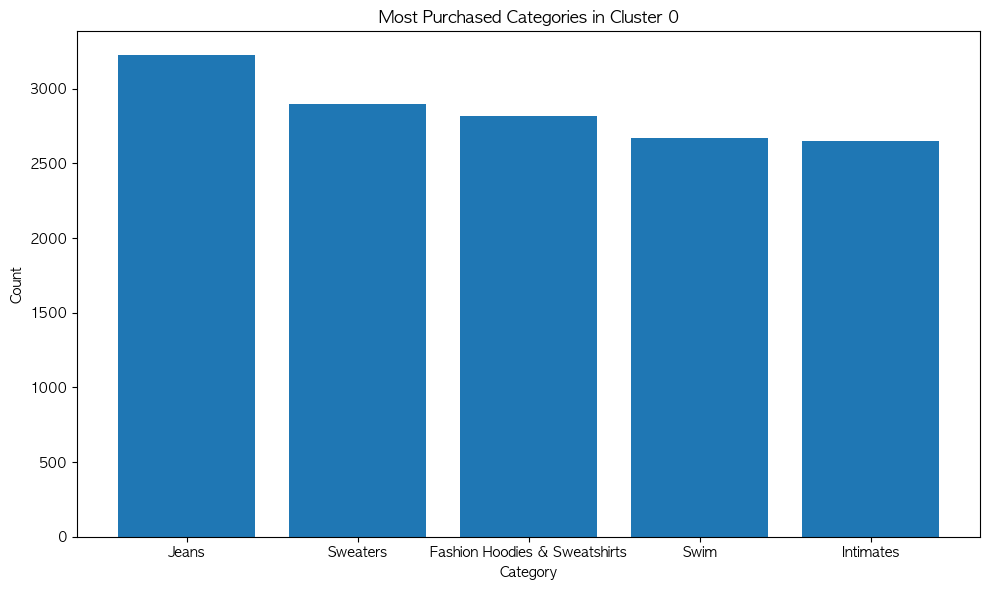

In [65]:
# 클러스터 0에 해당하는 행만 추출
cluster_0_data = most_purchased_categories[most_purchased_categories['cluster'] == 0]

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(cluster_0_data['category'], cluster_0_data['count'])

plt.title('Most Purchased Categories in Cluster 0')
plt.xlabel('Category')
plt.ylabel('Count')

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


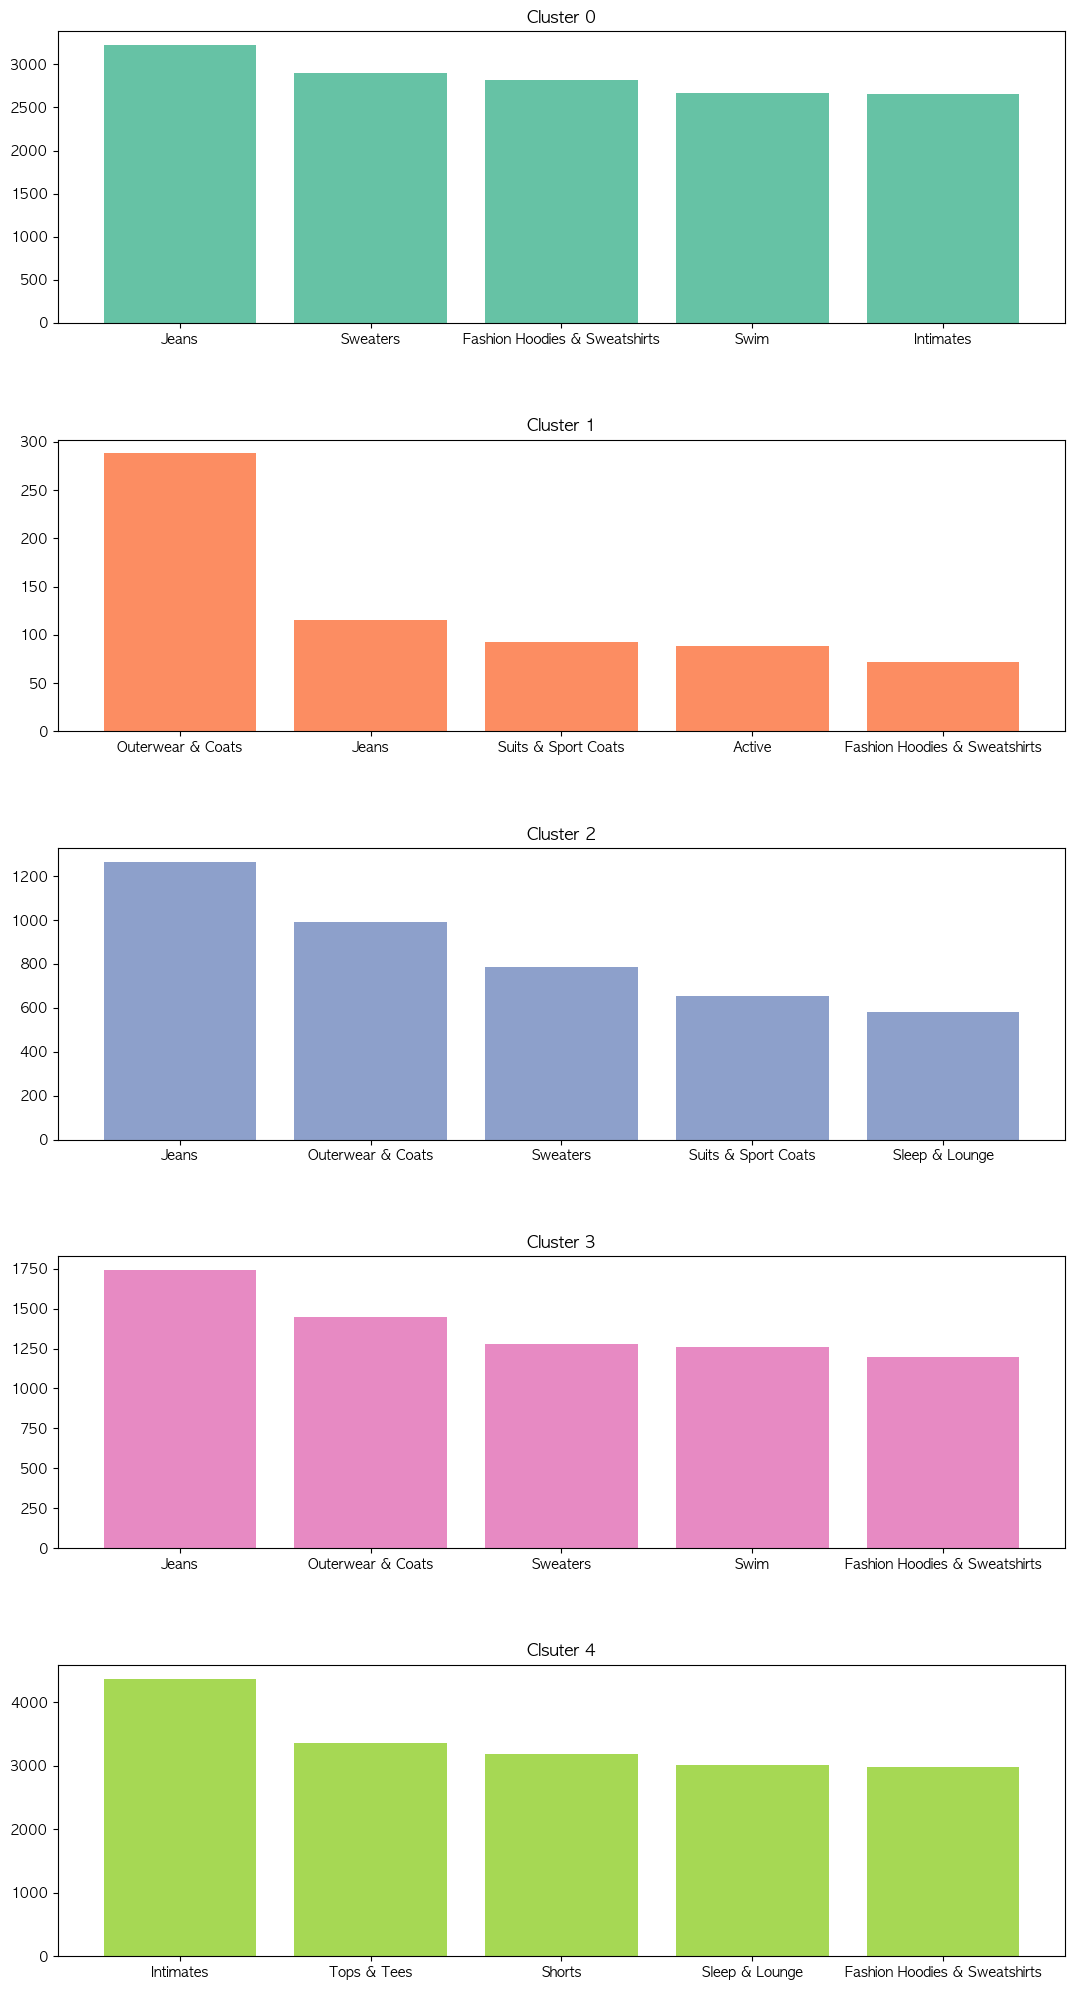

In [66]:
clusters = most_purchased_categories['cluster'].value_counts().index.to_list()

cluster_text = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Clsuter 4']

fig = plt.figure(figsize=(13,25))
fig.subplots_adjust(hspace=0.4)
palette = sns.color_palette("Set2", n_colors=len(clusters))

for i in range(len(clusters)):
    plt.subplot(5,1,i+1)
    data = most_purchased_categories[most_purchased_categories['cluster'] == clusters[i]]
    plt.bar(data['category'], data['count'], color=palette[i])
    plt.title(f"{cluster_text[i]}")
plt.show()


## cluster - brand 선호도 

In [67]:
cluster_brand_counts = rfm_merged.groupby(['cluster', 'brand']).size().reset_index(name='count')
cluster_brand_counts

# 각 클러스터에서 가장 많이 구매된 카테고리 선택
most_purchased_brands = cluster_brand_counts.groupby('cluster').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)
most_purchased_brands

/var/folders/qv/tqmmyp0s5dj996k_tcvqmtqm0000gn/T/ipykernel_2239/1113576717.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  most_purchased_brands = cluster_brand_counts.groupby('cluster').apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)


cluster              brand  count
0         0          Allegra K   1060
1         0       Calvin Klein    813
2         0           Carhartt    665
3         0             Volcom    405
4         0            Nautica    393
5         1     The North Face     59
6         1       Canada Goose     51
7         1          Arc'teryx     28
8         1             Diesel     26
9         1              Nobis     21
10        2             Diesel    237
11        2  7 For All Mankind    211
12        2          Allegra K    188
13        2       Calvin Klein    188
14        2      True Religion    175
15        3          Allegra K    470
16        3       Calvin Klein    363
17        3           Carhartt    309
18        3     Tommy Hilfiger    247
19        3             Diesel    232
20        4          Allegra K   2329
21        4       Calvin Klein    723
22        4              Hanes    635
23        4           Carhartt    549
24        4            Nautica    488

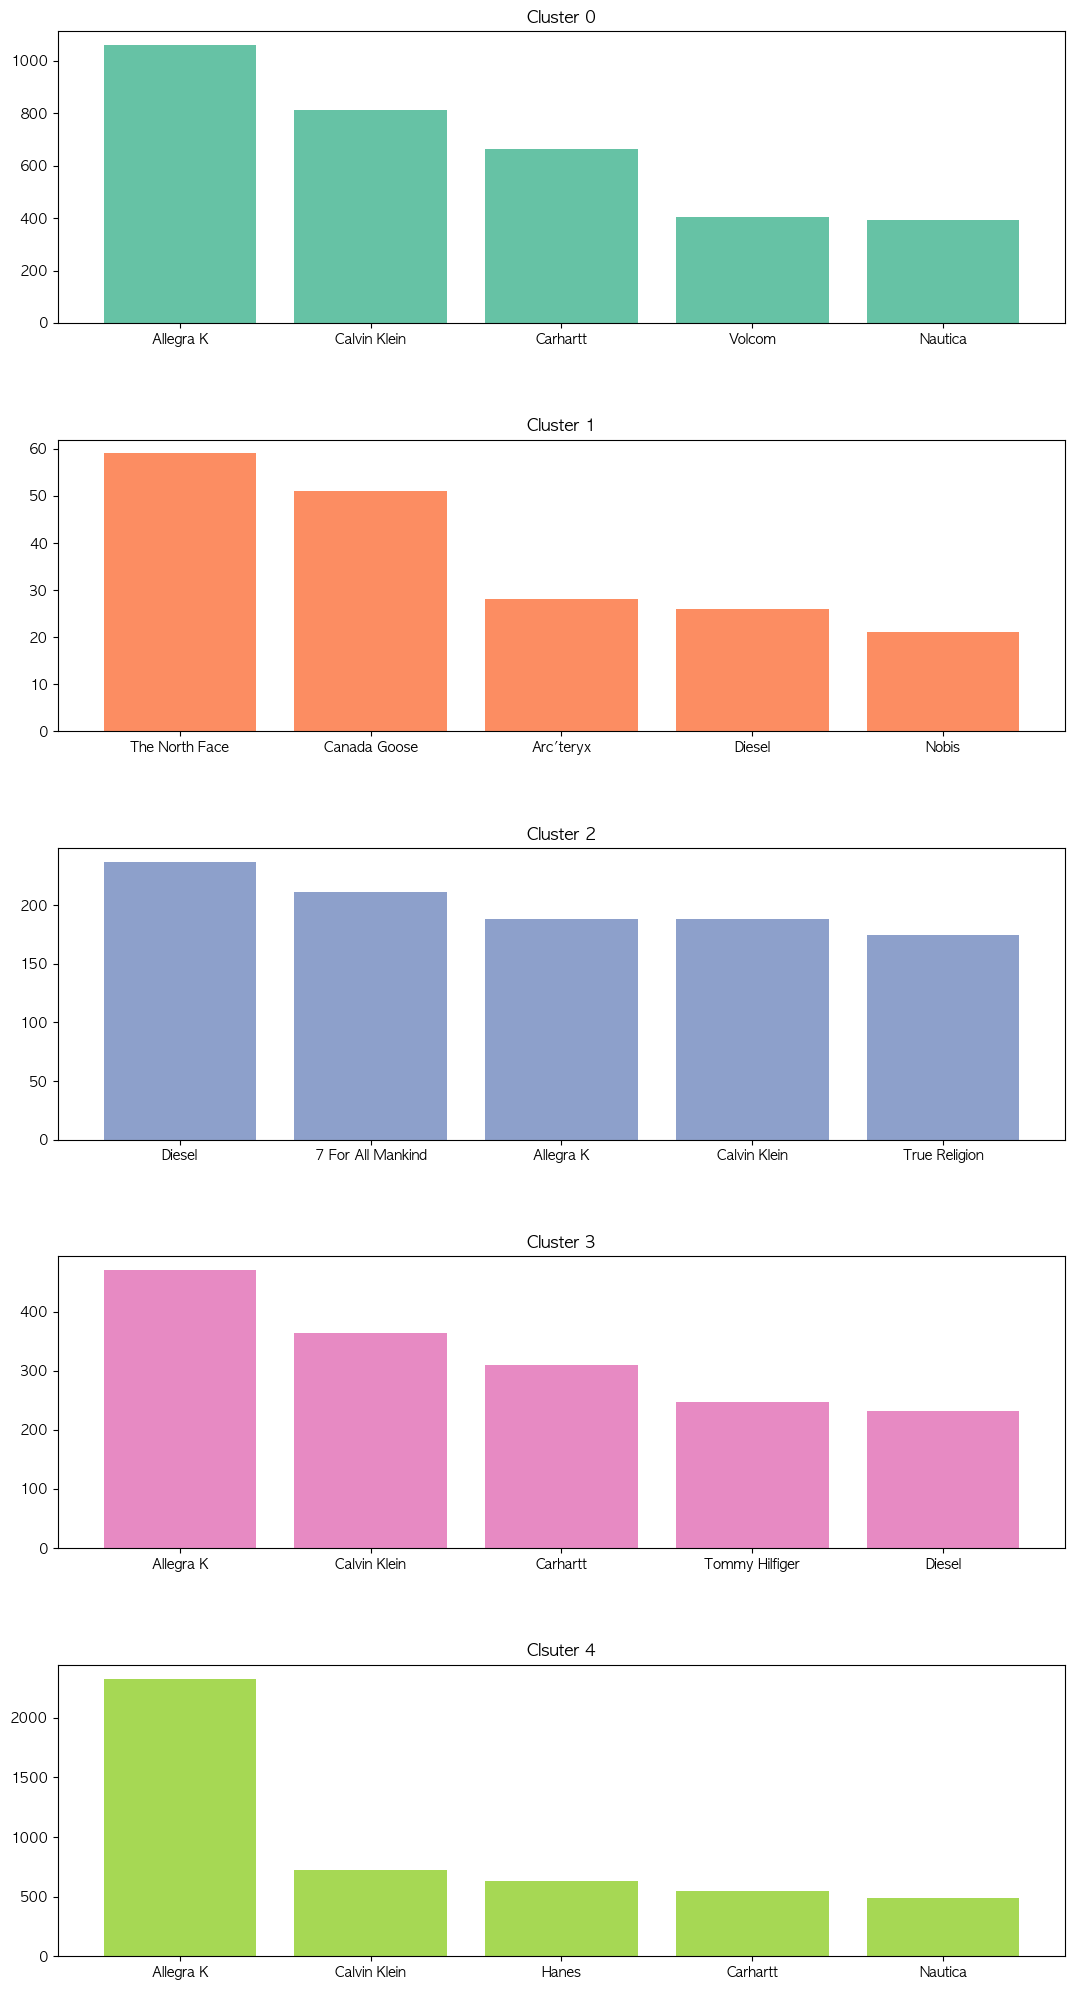

In [68]:
fig = plt.figure(figsize=(13,25))
fig.subplots_adjust(hspace=0.4)
palette = sns.color_palette("Set2", n_colors=len(clusters))

for i in range(len(clusters)):
    plt.subplot(5,1,i+1)
    data = most_purchased_brands[most_purchased_brands['cluster'] == clusters[i]]
    plt.bar(data['brand'], data['count'], color=palette[i])
    plt.title(f"{cluster_text[i]}")
plt.show()

# 고부가가치 고객 EDA

In [69]:
users = pd.read_parquet("/Users/hj/Documents/Four-A/dataset/Looker Ecommerce BigQuery Dataset/Optimization/users_optimized.parquet")
users

user_id   first_name last_name                           email  age  \
0          457      Timothy      Bush         timothybush@example.net   65   
1         6578    Elizabeth  Martinez   elizabethmartinez@example.com   34   
2        36280  Christopher   Mendoza  christophermendoza@example.net   13   
3        60193        Jimmy    Conner         jimmyconner@example.com   64   
4        64231      Natasha    Wilson       natashawilson@example.net   25   
...        ...          ...       ...                             ...  ...   
99995    93247      Crystal  Williams     crystalwilliams@example.com   36   
99996    59110       Daniel   Griffin       danielgriffin@example.org   12   
99997    57045       Olivia     Wiley         oliviawiley@example.org   53   
99998    73312        Emily      Bird           emilybird@example.org   16   
99999    77764      Deborah   Andrews      deborahandrews@example.com   67   

      gender          state                 street_address postal_code  \
0          M           Acre            87620 Johnson Hills   69917-400   
1          F           Acre              1705 Nielsen Land   69917-400   
2          M           Acre       125 Turner Isle Apt. 264   69917-400   
3          M           Acre      0966 Jose Branch Apt. 008   69917-400   
4          F           Acre   20798 Phillip Trail Apt. 392   69917-400   
...      ...            ...                            ...         ...   
99995      F  Île-de-France               984 Brady Branch       77120   
99996      M  Île-de-France  89560 Phillips Lakes Apt. 604       77160   
99997      F  Île-de-France               749 Ronald Forge       77320   
99998      F  Île-de-France            78117 Anderson Oval       77320   
99999      F  Île-de-France            922 Jeffrey Station       77320   

                     city country  user_latitude  user_longitude  \
0              Rio Branco  Brasil      -9.945568      -67.835610   
1              Rio Branco  Brasil      -9.945568      -67.835610   
2              Rio Branco  Brasil      -9.945568      -67.835610   
3              Rio Branco  Brasil      -9.945568      -67.835610   
4              Rio Branco  Brasil      -9.945568      -67.835610   
...                   ...     ...            ...             ...   
99995    Beautheil-Saints  France      48.789740        3.095796   
99996  Chenoise-Cucharmoy  France      48.589783        3.243343   
99997      Choisy-en-Brie  France      48.763993        3.319993   
99998      Choisy-en-Brie  France      48.763993        3.319993   
99999      Choisy-en-Brie  France      48.763993        3.319993   

      user_traffic_source           user_created_at  
0                  Search 2022-07-19 13:51:00+00:00  
1                  Search 2023-11-08 18:49:00+00:00  
2                   Email 2019-08-24 06:10:00+00:00  
3                  Search 2020-02-15 11:26:00+00:00  
4                  Search 2020-03-13 06:45:00+00:00  
...                   ...                       ...  
99995              Search 2021-02-13 01:36:00+00:00  
99996             Organic 2022-09-01 12:01:00+00:00  
99997              Search 2021-06-19 11:39:00+00:00  
99998              Search 2023-08-08 16:24:00+00:00  
99999              Search 2023-02-01 05:57:00+00:00  

[100000 rows x 15 columns]

Text(0.5, 0, 'age')

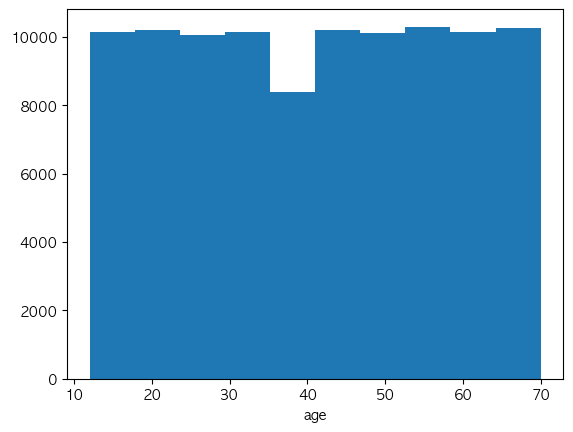

In [70]:
plt.hist(users['age'], bins=10)
plt.xlabel('age')
# plt.title('전체 고객 연령대')

In [71]:
rfm_user_merged = rfm_merged.merge(users, on='user_id', how='left')
rfm_user_merged

user_id  recency  frequency    monetary  cluster           G  \
0             1      499          1  159.990000        0  159.990000   
1             1      499          1  159.990000        0  159.990000   
2             1      499          1  159.990000        0  159.990000   
3             2      649          1   22.000000        4   22.000000   
4             3      115          4  100.550000        3  100.550000   
...         ...      ...        ...         ...      ...         ...   
117034    99996      261          2   61.935000        0   61.935000   
117035    99998      132          3   38.996667        4   38.996667   
117036    99998      132          3   38.996667        4   38.996667   
117037    99998      132          3   38.996667        4   38.996667   
117038   100000     1190          1  129.949997        0  129.949997   

                 K         S           M           Q         J         CLV  \
0       159.990000  0.320621    0.000000  159.990000  0.320621  480.611242   
1       159.990000  0.320621    0.000000  159.990000  0.320621  480.611242   
2       159.990000  0.320621    0.000000  159.990000  0.320621  480.611242   
3        22.000000  0.033898    0.000000   22.000000  0.033898   66.067797   
4       402.200001  3.497391  139.391898   25.137500  0.874348  671.651138   
...            ...       ...         ...         ...       ...         ...   
117034  123.870001  0.474598   42.930071   30.967500  0.237299  260.414469   
117035  116.990000  0.886288   42.842217   12.998889  0.295429  213.009490   
117036  116.990000  0.886288   42.842217   12.998889  0.295429  213.009490   
117037  116.990000  0.886288   42.842217   12.998889  0.295429  213.009490   
117038  129.949997  0.109202    0.000000  129.949997  0.109202  390.068394   

        recency_score  recency_score_2  frequency_2         G-1         K-1  \
0                  18              1.0            4  159.990000  639.959999   
1                  18              1.0            4  159.990000  639.959999   
2                  18              1.0            4  159.990000  639.959999   
3                   1              1.0            2   22.000000   44.000000   
4                   5             10.0            9  100.550000  904.950002   
...               ...              ...          ...         ...         ...   
117034             10              5.0            6   61.935000  371.610003   
117035              6             10.0            6   38.996667  233.980000   
117036              6             10.0            6   38.996667  233.980000   
117037              6             10.0            6   38.996667  233.980000   
117038              1              0.1            3  129.949997  389.849991   

               S-1         M-1        Q-1         J-1        CLV-1  \
0        35.553333  221.793235  39.997500    8.888333  1106.182400   
1        35.553333  221.793235  39.997500    8.888333  1106.182400   
2        35.553333  221.793235  39.997500    8.888333  1106.182400   
3        44.000000   15.249238  11.000000   22.000000   158.249238   
4       180.990000  220.930932  11.172222   20.110000  1438.703156   
...            ...         ...        ...         ...          ...   
117034   37.161000  110.972623  10.322500    6.193500   598.194627   
117035   38.996667   69.872647   6.499444    6.499444   394.844868   
117036   38.996667   69.872647   6.499444    6.499444   394.844868   
117037   38.996667   69.872647   6.499444    6.499444   394.844868   
117038  389.849991  142.764664  43.316666  129.949997  1225.681305   

        cluster_r2f2         G-2         K-2          S-2         M-2  \
0                  0  159.990000  639.959999   639.959999  221.793235   
1                  0  159.990000  639.959999   639.959999  221.793235   
2                  0  159.990000  639.959999   639.959999  221.793235   
3                  3   22.000000   44.000000    44.000000   15.249238   
4                  4  100.550000  904.950002    90.

In [72]:
high_clv_user = rfm_user_merged[(rfm_user_merged['cluster']==3) | (rfm_user_merged['cluster']==4)]
high_clv_user

user_id  recency  frequency    monetary  cluster           G  \
3             2      649          1   22.000000        4   22.000000   
4             3      115          4  100.550000        3  100.550000   
5             3      115          4  100.550000        3  100.550000   
6             3      115          4  100.550000        3  100.550000   
7             3      115          4  100.550000        3  100.550000   
...         ...      ...        ...         ...      ...         ...   
117029    99992      479          1   55.950001        4   55.950001   
117030    99992      479          1   55.950001        4   55.950001   
117035    99998      132          3   38.996667        4   38.996667   
117036    99998      132          3   38.996667        4   38.996667   
117037    99998      132          3   38.996667        4   38.996667   

                 K         S           M          Q         J         CLV  \
3        22.000000  0.033898    0.000000  22.000000  0.033898   66.067797   
4       402.200001  3.497391  139.391898  25.137500  0.874348  671.651138   
5       402.200001  3.497391  139.391898  25.137500  0.874348  671.651138   
6       402.200001  3.497391  139.391898  25.137500  0.874348  671.651138   
7       402.200001  3.497391  139.391898  25.137500  0.874348  671.651138   
...            ...       ...         ...        ...       ...         ...   
117029   55.950001  0.116806    0.000000  55.950001  0.116806  168.083614   
117030   55.950001  0.116806    0.000000  55.950001  0.116806  168.083614   
117035  116.990000  0.886288   42.842217  12.998889  0.295429  213.009490   
117036  116.990000  0.886288   42.842217  12.998889  0.295429  213.009490   
117037  116.990000  0.886288   42.842217  12.998889  0.295429  213.009490   

        recency_score  recency_score_2  frequency_2         G-1         K-1  \
3                   1              1.0            2   22.000000   44.000000   
4                   5             10.0            9  100.550000  904.950002   
5                   5             10.0            9  100.550000  904.950002   
6                   5             10.0            9  100.550000  904.950002   
7                   5             10.0            9  100.550000  904.950002   
...               ...              ...          ...         ...         ...   
117029             17              1.0            4   55.950001  223.800003   
117030             17              1.0            4   55.950001  223.800003   
117035              6             10.0            6   38.996667  233.980000   
117036              6             10.0            6   38.996667  233.980000   
117037              6             10.0            6   38.996667  233.980000   

               S-1         M-1        Q-1        J-1        CLV-1  \
3        44.000000   15.249238  11.000000  22.000000   158.249238   
4       180.990000  220.930932  11.172222  20.110000  1438.703156   
5       180.990000  220.930932  11.172222  20.110000  1438.703156   
6       180.990000  220.930932  11.172222  20.110000  1438.703156   
7       180.990000  220.930932  11.172222  20.110000  1438.703156   
...            ...         ...        ...        ...          ...   
117029   13.164706   77.563171  13.987500   3.291177   387.756557   
117030   13.164706   77.563171  13.987500   3.291177   387.756557   
117035   38.996667   69.872647   6.499444   6.499444   394.844868   
117036   38.996667   69.872647   6.499444   6.499444   394.844868   
117037   38.996667   69.872647   6.499444   6.499444   394.844868   

        cluster_r2f2         G-2         K-2         S-2         M-2  \
3                  3   22.000000   44.000000   44.000000   15.249238   
4                  4  100.550000  904.950002   90.495000  220.930932   
5                  4  100.550000  904.950002   90.495000  220.930932   
6                  4  100.550000  904.950002   90.495000  220.930932   
7                  4  100.550000  904.950002   90.495000  220.930932   
...     

Text(0.5, 1.0, '고부가가치 고객(cluster 3,4) 연령대')

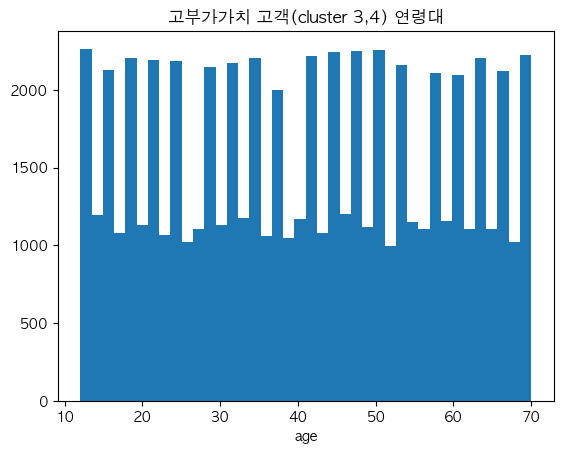

In [73]:
plt.hist(high_clv_user['age'],bins=40)
plt.xlabel('age')
plt.title('고부가가치 고객(cluster 3,4) 연령대')

In [74]:
high_clv_user.describe()

user_id       recency     frequency      monetary       cluster  \
count       64575.0  64575.000000  64575.000000  64575.000000  64575.000000   
mean   50333.184886    371.663864      1.786171     73.270820      3.706961   
min             2.0      1.000000      1.000000      0.020000      3.000000   
25%         25584.5     96.000000      1.000000     30.950001      3.000000   
50%         50738.0    258.000000      2.000000     49.990002      4.000000   
75%         75021.5    548.000000      2.000000     95.892501      4.000000   
max         99998.0   1783.000000      4.000000    372.495001      4.000000   
std    28771.750775    353.323388      0.921816     61.960475      0.455160   

                  G             K             S             M             Q  \
count  64575.000000  64575.000000  64575.000000  64575.000000  64575.000000   
mean      73.270820    155.647878      3.899961     47.893521     42.365213   
min        0.020000      0.020000      0.000076      0.000000      0.020000   
25%       30.950001     38.500000      0.096955      0.000000     20.649688   
50%       49.990002     69.490000      0.357463     13.509438     34.000000   
75%       95.892501    289.060001      1.521845    102.027800     59.990002   
max      372.495001   1009.890003    930.430000    350.001204    186.247500   
std       61.960475    173.848234     22.858903     66.203198     28.762693   

                  J           CLV  recency_score  recency_score_2  \
count  64575.000000  64575.000000   64575.000000     64575.000000   
mean       1.652726    324.730120       6.985521         6.934487   
min        0.000076      0.060153       1.000000         0.100000   
25%        0.078885    107.529666       2.000000         1.000000   
50%        0.223507    180.677966       5.000000         5.000000   
75%        0.746500    563.191182      11.000000        10.000000   
max      310.143333   2925.255056      22.000000        20.000000   
std        8.533551    321.889807       5.848732         6.608637   

        frequency_2           G-1           K-1           S-1           M-1  \
count  64575.000000  64575.000000  64575.000000  64575.000000  64575.000000   
mean       4.904700     73.270820    470.100567    150.426356    125.540411   
min        2.000000      0.020000      0.080000      0.008000      0.027726   
25%        2.000000     30.950001     88.000000     14.599342     30.498476   
50%        4.000000     49.990002    178.760002     52.222222     60.412690   
75%        7.000000     95.892501    793.597489    151.330911    209.558392   
max       15.000000    372.495001   4279.799997   3089.949999    816.116751   
std        2.992722     61.960475    596.314421    287.336469    141.037953   

                Q-1           J-1         CLV-1  cluster_r2f2           G-2  \
count  64575.000000  64575.000000  64575.000000  64575.000000  64575.000000   
mean      15.735402     24.994681    860.068237      2.863848     73.270820   
min        0.005000      0.002000      0.142726      0.000000      0.020000   
25%        8.377045      4.481250    210.185359      3.000000     30.950001   
50%       13.092381     11.990000    385.754403      3.000000     49.990002   
75%       21.467778     31.500000   1334.795584      3.000000     95.892501   
max       93.123750    372.495001   7540.276778      4.000000    372.495001   
std        9.708210     35.624405   1021.155489      0.987572     61.960475   

                K-2           S-2           M-2           Q-2           J-2  \
count  64575.000000  64575.000000  64575.000000  64575.000000  64575.000000   
mean     470.100567    611.687700    125.540411     15.735402    115.565539   
min        0.080000      0.016000      0.027726      0.005000      0.004000   
25%       88.000000     16.666667     30.498476      8.377045      4.797500   
50%      178.760002     66.653336     60.412690     13.092381     13.449334   
75%      793.597489    280.327498    209.558392     21.467778     54

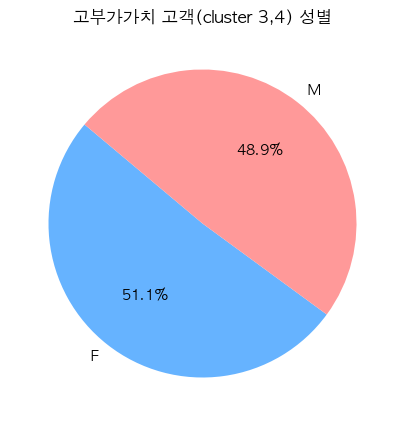

In [75]:
gender_counts = high_clv_user['gender'].value_counts()

# 시각화
labels = high_clv_user['gender']
sizes = high_clv_user['user_id'].count()

colors = ['#66b3ff','#ff9999']

# 파이 차트 생성
plt.figure(figsize=(5, 5))
plt.pie(gender_counts, labels=gender_counts.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('고부가가치 고객(cluster 3,4) 성별')
plt.show()

In [76]:
rfm_merged[rfm_merged['user_id']==17].sort_values('created_at')

user_id  recency  frequency    monetary  cluster           G           K  \
25       17     1126          3  249.329995        3  249.329995  747.989986   
22       17     1126          3  249.329995        3  249.329995  747.989986   
21       17     1126          3  249.329995        3  249.329995  747.989986   
24       17     1126          3  249.329995        3  249.329995  747.989986   
23       17     1126          3  249.329995        3  249.329995  747.989986   
27       17     1126          3  249.329995        3  249.329995  747.989986   
26       17     1126          3  249.329995        3  249.329995  747.989986   

          S           M          Q        J          CLV  recency_score  \
25  0.66429  273.916997  83.109998  0.22143  1355.232697              1   
22  0.66429  273.916997  83.109998  0.22143  1355.232697              1   
21  0.66429  273.916997  83.109998  0.22143  1355.232697              1   
24  0.66429  273.916997  83.109998  0.22143  1355.232697              1   
23  0.66429  273.916997  83.109998  0.22143  1355.232697              1   
27  0.66429  273.916997  83.109998  0.22143  1355.232697              1   
26  0.66429  273.916997  83.109998  0.22143  1355.232697              1   

    recency_score_2  frequency_2         G-1          K-1          S-1  \
25              0.1           10  249.329995  2493.299955  2493.299955   
22              0.1           10  249.329995  2493.299955  2493.299955   
21              0.1           10  249.329995  2493.299955  2493.299955   
24              0.1           10  249.329995  2493.299955  2493.299955   
23              0.1           10  249.329995  2493.299955  2493.299955   
27              0.1           10  249.329995  2493.299955  2493.299955   
26              0.1           10  249.329995  2493.299955  2493.299955   

           M-1     Q-1         J-1        CLV-1  cluster_r2f2         G-2  \
25  574.103531  24.933  249.329995  6084.296431             1  249.329995   
22  574.103531  24.933  249.329995  6084.296431             1  249.329995   
21  574.103531  24.933  249.329995  6084.296431             1  249.329995   
24  574.103531  24.933  249.329995  6084.296431             1  249.329995   
23  574.103531  24.933  249.329995  6084.296431             1  249.329995   
27  574.103531  24.933  249.329995  6084.296431             1  249.329995   
26  574.103531  24.933  249.329995  6084.296431             1  249.329995   

            K-2           S-2         M-2     Q-2          J-2         CLV-2  \
25  2493.299955  24932.999547  574.103531  24.933  2493.299955  30767.965983   
22  2493.299955  24932.999547  574.103531  24.933  2493.299955  30767.965983   
21  2493.299955  24932.999547  574.103531  24.933  2493.299955  30767.965983   
24  2493.299955  24932.999547  574.103531  24.933  2493.299955  30767.965983   
23  2493.299955  24932.999547  574.103531  24.933  2493.299955  30767.965983   
27  2493.299955  24932.999547  574.103531  24.933  2493.299955  30767.965983   
26  2493.299955  24932.999547  574.103531  24.933  2493.299955  30767.965983   

    cluster_r3f2  order_item_id  order_id  product_id  inventory_item_id  \
25             3             37        24       24171                103   
22             3             38        24       28283                105   
21             3             43        26       16381                120   
24             3             39        25       23584                108   
23             3             41        25       29058                114   
27             3             40        25       18612                112   
26             3             42        25       23645                116   

      status          created_at                shipped_at  \
25  Complete 2019-06-17 08:42:54 2019-06-15 13:55:00+00:00   
22  Complete 2019-06-18 11:18:10 2019-06-15 13:55:00+00:00   
21   Shipped 2020-09-18 10:15:08 2020-09-20 20:20:00+00:00   
24  Complete 2020-10-29 08:44:10 2020-10-31 14:57:00+0

In [77]:
# 클러스터 3에 해당하는 데이터 추출
cluster_3_data = rfm_user_merged[rfm_user_merged['cluster'] == 3]

# 구매 주기 분석
purchase_frequency = cluster_3_data['recency'].mean()  # 평균 구매 주기

# 구매 빈도 분석
purchase_count = cluster_3_data.shape[0]  # 구매 횟수

# 평균 구매금액 분석
average_purchase_amount = cluster_3_data['monetary'].mean()  # 평균 구매금액

# 결과 출력
print("구매 주기 (평균): {:.2f} 일".format(purchase_frequency))
print("구매 빈도: {}".format(purchase_count))
print("평균 구매금액: {:.2f}".format(average_purchase_amount))


구매 주기 (평균): 275.00 일
구매 빈도: 18923
평균 구매금액: 153.60


In [78]:
rfm_user_merged.groupby('cluster').agg({
    'recency' : ['mean', 'min', 'max'],  ## 구매 주기
    'frequency' : ['mean', 'min', 'max'],  ## 구매 빈도 
    'monetary' : ['mean', 'min', 'max'],  ## 한번 주문시 평균 금액
    'K' : ['mean', 'min', 'max', 'sum'], ##  총 구매금액 
    'CLV' : ['mean', 'min', 'max', 'count']
})

recency           frequency            monetary              \
               mean min   max      mean min max        mean         min   
cluster                                                                   
0        366.934223   1  1789  1.801124   1   4  100.251007   35.422501   
1        403.139231   1  1734  1.515591   1   4  577.471840  269.847500   
2        452.772556   1  1769  1.000000   1   1  263.473317  183.290001   
3        274.996618   1  1582  2.776568   2   4  153.598094   67.730000   
4        411.732958   1  1783  1.375646   1   4   39.974733    0.020000   

                               K                                         \
                 max        mean         min          max           sum   
cluster                                                                   
0         183.129999  160.689616   82.000000   270.359998  6.547138e+06   
1        1341.489998  790.820297  462.490005  1405.619991  1.090541e+06   
2         461.140000  263.473317  183.290001   461.140000  2.724578e+06   
3         372.495001  401.345161  262.269993  1009.890003  7.594654e+06   
4          82.389999   53.805031    0.020000   140.770002  2.456307e+06   

                 CLV                                   
                mean          min          max  count  
cluster                                                
0         378.882510   235.321851   892.199993  40744  
1        2006.539980  1388.126963  4101.126565   1379  
2         797.493380   551.221050  2179.749947  10341  
3         774.551852   453.443694  2925.255056  18923  
4         138.276588     0.060153   412.491034  45652

## 구매가 활발한 시간대

In [79]:
rfm_user_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117039 entries, 0 to 117038
Data columns (total 63 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   user_id                 117039 non-null  Int32              
 1   recency                 117039 non-null  int64              
 2   frequency               117039 non-null  int64              
 3   monetary                117039 non-null  float64            
 4   cluster                 117039 non-null  int32              
 5   G                       117039 non-null  float64            
 6   K                       117039 non-null  float64            
 7   S                       117039 non-null  float64            
 8   M                       117039 non-null  float64            
 9   Q                       117039 non-null  float64            
 10  J                       117039 non-null  float64            
 11  CLV                     11

In [80]:
rfm_user_merged['order_hour'] = rfm_user_merged['created_at'].dt.hour

hourly_purchase_counts = rfm_user_merged['order_hour'].value_counts().sort_index()
hourly_purchase_counts

order_hour
0     6126
1     6138
2     5920
3     6059
4     5916
5     6105
6     6171
7     6354
8     6205
9     6224
10    6315
11    6307
12    6191
13    6173
14    5980
15    5705
16    3994
17    2530
18    1039
19      17
20     561
21    2069
22    3727
23    5213
Name: count, dtype: int64

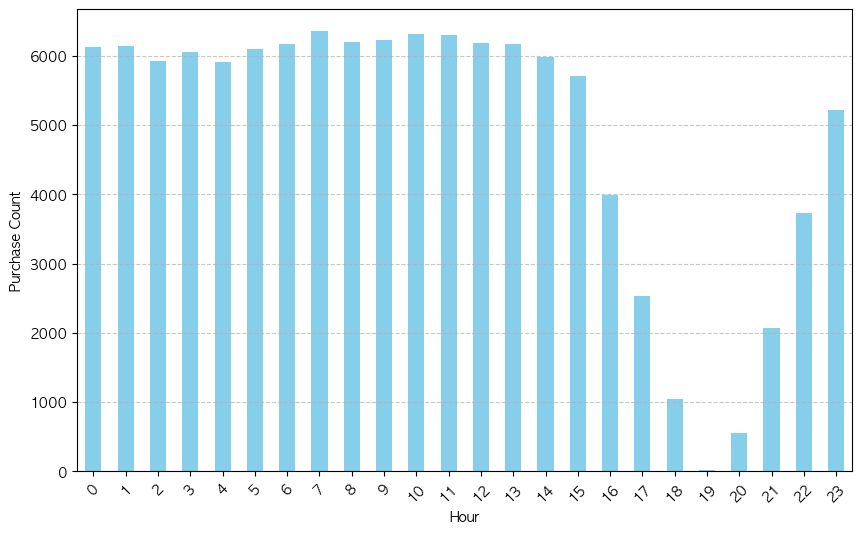

In [81]:
plt.figure(figsize=(10, 6))
hourly_purchase_counts.plot(kind='bar', color='skyblue')
# plt.title('전체 고객 - 구매 활발한 시간대')
plt.xlabel('Hour')
plt.ylabel('Purchase Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [82]:
rfm_user_merged['order_dayofweek'] = rfm_user_merged['created_at'].dt.dayofweek

day_of_week_labels = {0: 'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}

dow_purchase_counts = rfm_user_merged['order_dayofweek'].map(day_of_week_labels).value_counts().reindex(day_of_week_labels.values())
dow_purchase_counts

order_dayofweek
Mon    16734
Tue    16764
Wed    16814
Thu    16850
Fri    16364
Sat    16672
Sun    16841
Name: count, dtype: int64

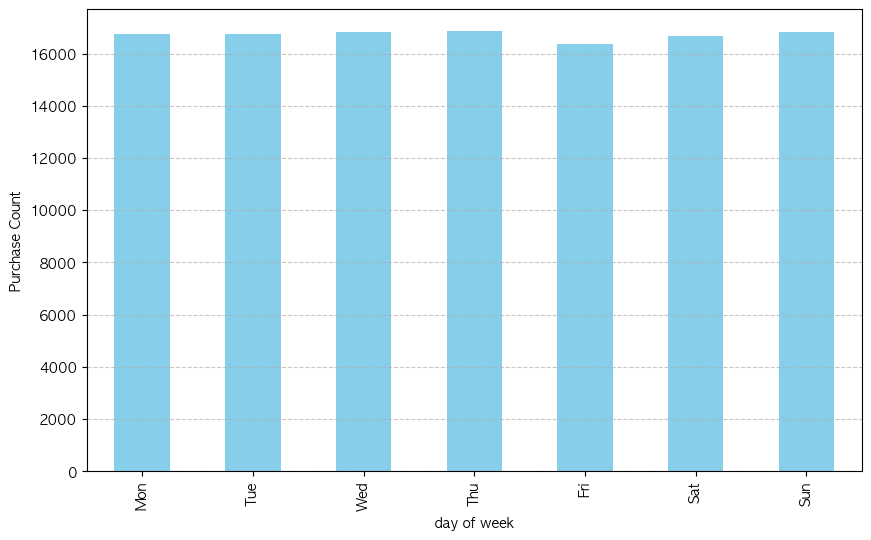

In [83]:
plt.figure(figsize=(10, 6))
dow_purchase_counts.plot(kind='bar', color='skyblue')
# plt.title('전체 고객 - 구매 활발한 요일')
plt.xlabel('day of week')
plt.ylabel('Purchase Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [84]:
cluster_1 = rfm_user_merged[rfm_user_merged['cluster']==1]
cluster_1

user_id  recency  frequency    monetary  cluster           G  \
588         516        1          1  483.990002        1  483.990002   
589         516        1          1  483.990002        1  483.990002   
682         596     1225          1  489.299995        1  489.299995   
683         596     1225          1  489.299995        1  489.299995   
684         596     1225          1  489.299995        1  489.299995   
...         ...      ...        ...         ...      ...         ...   
116079    99146       48          2  501.245001        1  501.245001   
116279    99322      606          1  792.000000        1  792.000000   
116280    99322      606          1  792.000000        1  792.000000   
116417    99439      164          1  473.000000        1  473.000000   
116418    99439      164          1  473.000000        1  473.000000   

                  K           S           M           Q           J  \
588      483.990002  483.990002    0.000000  483.990002  483.990002   
589      483.990002  483.990002    0.000000  483.990002  483.990002   
682      489.299995    0.399429    0.000000  489.299995    0.399429   
683      489.299995    0.399429    0.000000  489.299995    0.399429   
684      489.299995    0.399429    0.000000  489.299995    0.399429   
...             ...         ...         ...         ...         ...   
116079  1002.490002   20.885208  347.436559  250.622500   10.442604   
116279   792.000000    1.306931    0.000000  792.000000    1.306931   
116280   792.000000    1.306931    0.000000  792.000000    1.306931   
116417   473.000000    2.884146    0.000000  473.000000    2.884146   
116418   473.000000    2.884146    0.000000  473.000000    2.884146   

                CLV  recency_score  recency_score_2  frequency_2         G-1  \
588     2419.950008              2             20.0            3  483.990002   
589     2419.950008              2             20.0            3  483.990002   
682     1468.698843              1              0.1            5  489.299995   
683     1468.698843              1              0.1            5  489.299995   
684     1468.698843              1              0.1            5  489.299995   
...             ...            ...              ...          ...         ...   
116079  2133.121875              3             15.0            5  501.245001   
116279  2378.613861              1              1.0            5  792.000000   
116280  2378.613861              1              1.0            5  792.000000   
116417  1424.768293              7             10.0            3  473.000000   
116418  1424.768293              7             10.0            3  473.000000   

                K-1          S-1          M-1         Q-1         J-1  \
588     1451.970005   725.985003   531.717363  161.330001  241.995001   
589     1451.970005   725.985003   531.717363  161.330001  241.995001   
682     2446.499977  2446.499977   787.497963   97.859999  489.299995   
683     2446.499977  2446.499977   787.497963   97.859999  489.299995   
684     2446.499977  2446.499977   787.497963   97.859999  489.299995   
...             ...          ...          ...         ...         ...   
116079  2506.225004   835.408335   806.722708  100.249000  167.081667   
116279  3960.000000  3960.000000  1274.674827  158.400000  792.000000   
116280  3960.000000  3960.000000  1274.674827  158.400000  792.000000   
116417  1419.000000   202.714286   519.643613  157.666667   67.571429   
116418  1419.000000   202.714286   519.643613  157.666667   67.571429   

               CLV-1  cluster_r2f2         G-2          K-2           S-2  \
588      3596.987374             2  483.990002  1451.970005     72.598500   
589      3596.987374             2  483.990002  1451.970005     72.598500   
682      6756.957907             1  489.299995  2446.499977  24464.999771   
683      6756.957907             1  489.299995  2446.499977  24464.999771   
684      6756.957907             1  489.299995  2446.499977  24464.

In [85]:
rfm_user_merged[rfm_user_merged['user_id']==596]

user_id  recency  frequency    monetary  cluster           G           K  \
682      596     1225          1  489.299995        1  489.299995  489.299995   
683      596     1225          1  489.299995        1  489.299995  489.299995   
684      596     1225          1  489.299995        1  489.299995  489.299995   
685      596     1225          1  489.299995        1  489.299995  489.299995   

            S    M           Q         J          CLV  recency_score  \
682  0.399429  0.0  489.299995  0.399429  1468.698843              1   
683  0.399429  0.0  489.299995  0.399429  1468.698843              1   
684  0.399429  0.0  489.299995  0.399429  1468.698843              1   
685  0.399429  0.0  489.299995  0.399429  1468.698843              1   

     recency_score_2  frequency_2         G-1          K-1          S-1  \
682              0.1            5  489.299995  2446.499977  2446.499977   
683              0.1            5  489.299995  2446.499977  2446.499977   
684              0.1            5  489.299995  2446.499977  2446.499977   
685              0.1            5  489.299995  2446.499977  2446.499977   

            M-1        Q-1         J-1        CLV-1  cluster_r2f2         G-2  \
682  787.497963  97.859999  489.299995  6756.957907             1  489.299995   
683  787.497963  97.859999  489.299995  6756.957907             1  489.299995   
684  787.497963  97.859999  489.299995  6756.957907             1  489.299995   
685  787.497963  97.859999  489.299995  6756.957907             1  489.299995   

             K-2           S-2         M-2        Q-2          J-2  \
682  2446.499977  24464.999771  787.497963  97.859999  4892.999954   
683  2446.499977  24464.999771  787.497963  97.859999  4892.999954   
684  2446.499977  24464.999771  787.497963  97.859999  4892.999954   
685  2446.499977  24464.999771  787.497963  97.859999  4892.999954   

           CLV-2  cluster_r3f2  order_item_id  order_id  product_id  \
682  33179.15766             3           1096       745       28372   
683  33179.15766             3           1094       745       26828   
684  33179.15766             3           1093       745       24216   
685  33179.15766             3           1095       745       20733   

     inventory_item_id      status          created_at shipped_at  \
682               2999  Processing 2020-07-23 14:18:26        NaT   
683               2995  Processing 2020-07-20 13:23:09        NaT   
684               2993  Processing 2020-07-20 14:33:17        NaT   
685               2997  Processing 2020-07-24 14:52:04        NaT   

    delivered_at returned_at  sale_price       cost           category  \
682          NaT         NaT   51.750000  23.132250        Accessories   
683          NaT         NaT  124.599998  44.482199     Sleep & Lounge   
684          NaT         NaT  139.000000  63.384000  Outerwear & Coats   
685          NaT         NaT  173.949997  84.365748              Jeans   

                                          product_name              brand  \
682  Williams Cashmere Men's 100% Cashmere Solid Kn...  Williams Cashmere   
683  Pendleton Men's Chief Joseph Terry Velore Bath...          Pendleton   
684         Sons of Anarchy Men's Highway Denim Jacket    Sons of Anarchy   
685  Diesel Men's Larkee Regular Straight Leg 801Z ...             Diesel   

     retail_price department                               sku  \
682     51.750000        Men  DD2CC2088B77D344F7B5EC13E6FF4922   
683    124.599998        Men  A8AECE0882371F438C829BCCB995A927   
684    139.000000        Men  EC23187ECC4E0C6EB40CD187DB4A865C   
685    173.949997        Men  67EB5E92661B494826ADD1D403863257   

     distribution_center_id first_name last_name                     email  \
682                       2    Russell     Scott  russellscott@example.com   
683                       9    Russell     Scott  russellscott@example.com   
684                       3    Russell     Scott  russellscott@example.com   
685